## Rossmann sales analysis

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import datetime
from pandas import Series

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize

#from matplotlib import pyplot
import seaborn as sns 
%matplotlib inline

from sklearn import datasets, linear_model

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb

from tqdm import tqdm_notebook


In [ ]:
import matplotlib as mpl
#mpl.rcParams['animation.ffmpeg_path'] = 'ffmpeg'
#mpl.rcParams['animation.ffmpeg_path']

In [ ]:
path='C:/Users/a.czepierga/Desktop/Machine Learning AI/rossmann/all (1)'
#path='C:/Users/Aleksandra/PycharmProjects/rossmann'

### Import and check data

In [ ]:
# importing train data
train = pd.read_csv(path+"/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

test = pd.read_csv(path+"/test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv(path+"/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

In [660]:
print("Total: ", train.shape)
train.head(5)

Total:  (1017209, 8)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

In [661]:
print("Total: ", test.shape)
test.head(5)

Total:  (41088, 7)


Id  Store  DayOfWeek  Open  Promo StateHoliday  SchoolHoliday
Date                                                                     
2015-09-17   1      1          4   1.0      1            0              0
2015-09-17   2      3          4   1.0      1            0              0
2015-09-17   3      7          4   1.0      1            0              0
2015-09-17   4      8          4   1.0      1            0              0
2015-09-17   5      9          4   1.0      1            0              0

### Analyze train data

In [662]:
# Drop duplicates
train = train.drop_duplicates()
store = store.drop_duplicates()
# drop sales == 0 observations
train = train[train.Sales != 0]

In [663]:
# date extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['Date'] = train.index

In [664]:
train.head(5)

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear       Date  
Date                                                                
2015-07-31              1  2015      7   31          31 2015-07-31  
2015-07-31              1  2015      7   31          31 2015-07-31  
2015-07-31              1  2015      7   31          31 2015-07-31  
2015-07-31              1  2015      7   31          31 2015-07-31  
2015-07-31              1  2015      7   31          31 2015-07-31

In [665]:
# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844179.000000
mean          9.493670
std           2.197518
min           2.749075
25%           7.895549
50%           9.250000
75%          10.899784
max          64.957854
Name: SalePerCustomer, dtype: float64

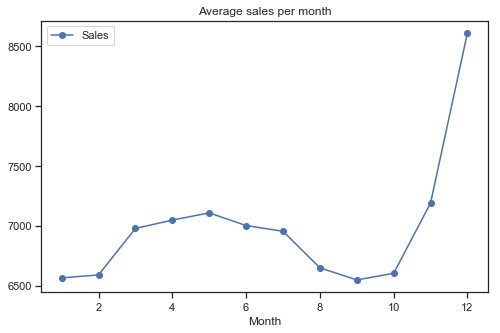

In [674]:
#Average sales per month
average_sales_per_month = train.groupby('Month')["Sales"].mean()
plt.figure(figsize=(8, 5))
average_sales_per_month.plot(legend=True, marker='o', title="Average sales per month")

In [675]:
# Increase of sales in December

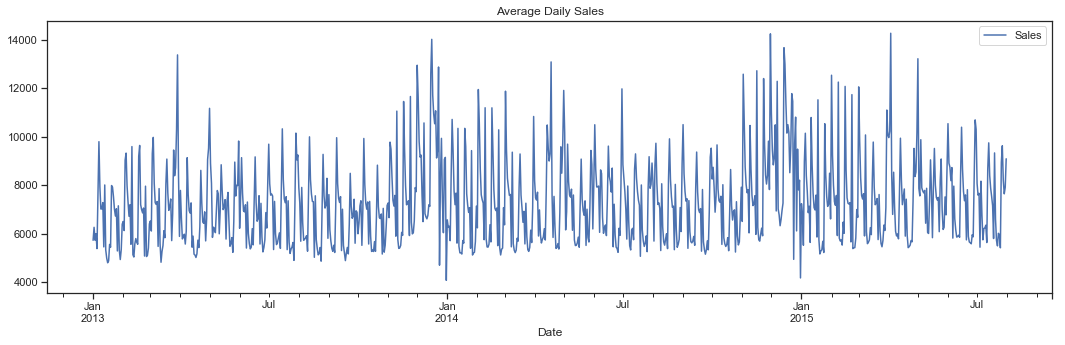

In [676]:
#Average sales per day
average_sales_per_day = train.groupby('Date')["Sales"].mean()
fig = plt.subplots(1,1, sharex=True, figsize=(18, 5))
average_sales_per_day.plot(legend=True, title="Average Daily Sales")

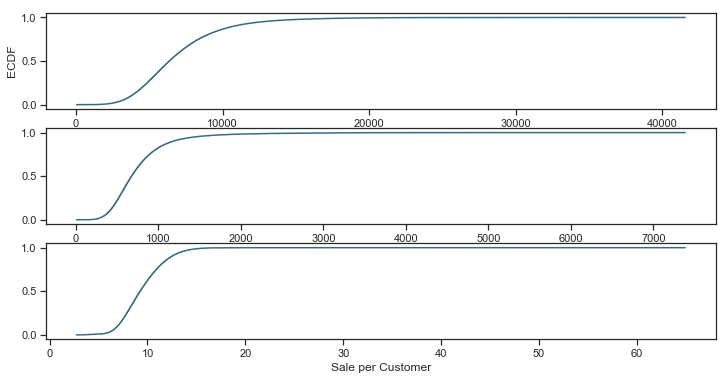

In [677]:
#ECDF

sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [678]:
# Add interpretation

In [679]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

Empty DataFrame
Columns: [Store, DayOfWeek, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, Year, Month, Day, WeekOfYear, Date, SalePerCustomer]
Index: []

In [680]:
closed_train_store_data = train["Store"][train["Open"] == 0].values
closed_train_store_data

array([], dtype=int64)

In [681]:
closed_store_data = test["Id"][test["Open"] == 0].values
closed_store_data

array([  544,   677,   841, ..., 40230, 40231, 40232], dtype=int64)

In [682]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("Total: ", zero_sales.shape)
zero_sales.head(5)

Total:  (0, 14)


Empty DataFrame
Columns: [Store, DayOfWeek, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, Year, Month, Day, WeekOfYear, Date, SalePerCustomer]
Index: []

In [683]:
print("Closed stores and days which didn't have any sales removed from the forecast.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("Total: ", train.shape)

Closed stores and days which didn't have any sales removed from the forecast.
Total:  (844179, 14)


In [684]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [685]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [686]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [687]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [688]:
# replace NA's by 0# replac 
store.fillna(0, inplace = True)

In [689]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              0.0              0.0   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              0.0              0.0   
4                    2015.0       0              0.0              0.0   

     PromoInterval  
0                0  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3                0  
4                0

In [690]:
print("Joining train dataset with store details")

train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("Total: ", train_store.shape)
train_store.head()

Joining train dataset with store details
Total:  (844179, 23)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month      ...        SalePerCustomer  StoreType  \
0              1  2015      7      ...               9.482883          c   
1              1  2015      7      ...               9.194139          c   
2              1  2015      7      ...               9.143403          c   
3              1  2015      7      ...               8.948214          c   
4              1  2015      7      ...               9.970588          c   

  Assortment  CompetitionDistance CompetitionOpenSinceMonth  \
0          a               1270.0                       9.0   
1          a               1270.0                       9.0   
2          a               1270.0                       9.0   
3          a               1270.0                       9.0   
4          a               1270.0                       9.0   

  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                   2008.0       0              0.0              0.0   
1                   2008.0       0              0.0              0.0   
2                   2008.0       0              0.0              0.0   
3                   2008.0       0              0.0              0.0   
4                   2008.0       0              0.0              0.0   

   PromoInterval  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 23 columns]

In [691]:
# Store types
train_store.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%  \
StoreType                                                                 
a          456942.0   6926.197738  3277.334816    46.0  4696.00  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112952.0   6933.245148  2897.060467   133.0  4916.00  6408.0   
d          258725.0   6822.448434  2556.436554   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8407.00  41551.0  
b          13184.25  38722.0  
c           8350.00  31448.0  
d           8124.00  38037.0

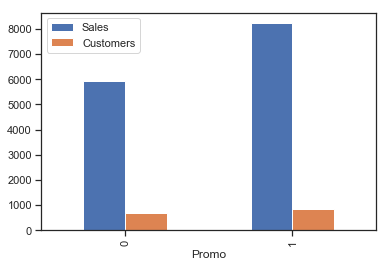

In [692]:
avg_promotion = train_store[['Sales', 'Customers', 'Promo']].groupby('Promo').mean()
avg_promotion.plot(kind='bar')

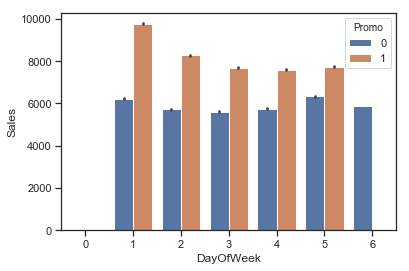

In [693]:
avg_hist_by_month = train_store[['Sales', 'Customers', 'Promo']].groupby(['Promo']).mean()
sns.barplot(x="DayOfWeek", y="Sales", hue="Promo", order=[0, 1, 2, 3, 4, 5, 6], data=train)

In [694]:
# Sales by store type
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

Customers       Sales
StoreType                       
a          363489981  3164870647
b           31465616   159231395
c           92117637   783123906
d          156881263  1765137971

In [695]:
#sns.relplot(x="Month", y="Sales", hue="StoreType",
#            col="StoreType", row="Promo", height=3,
#            kind="line", estimator=None, data=train_store);

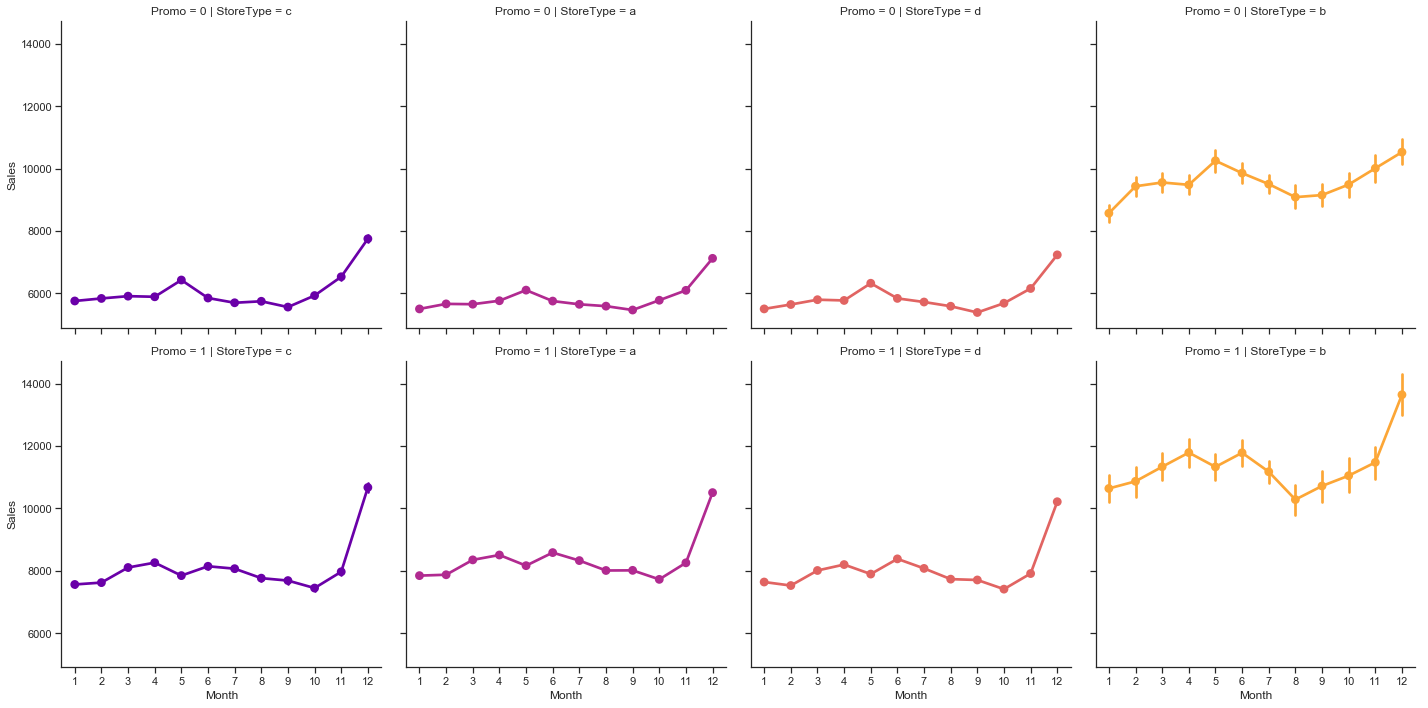

In [696]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

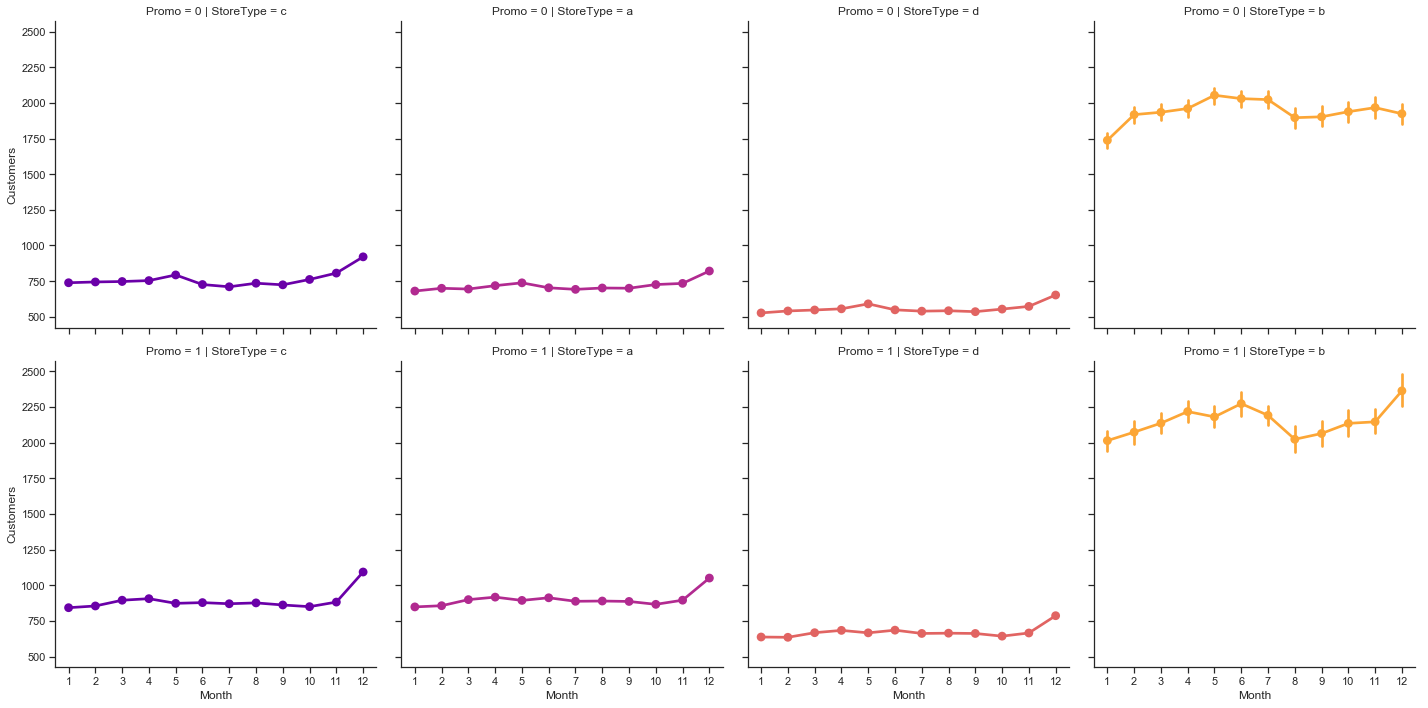

In [697]:
# customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

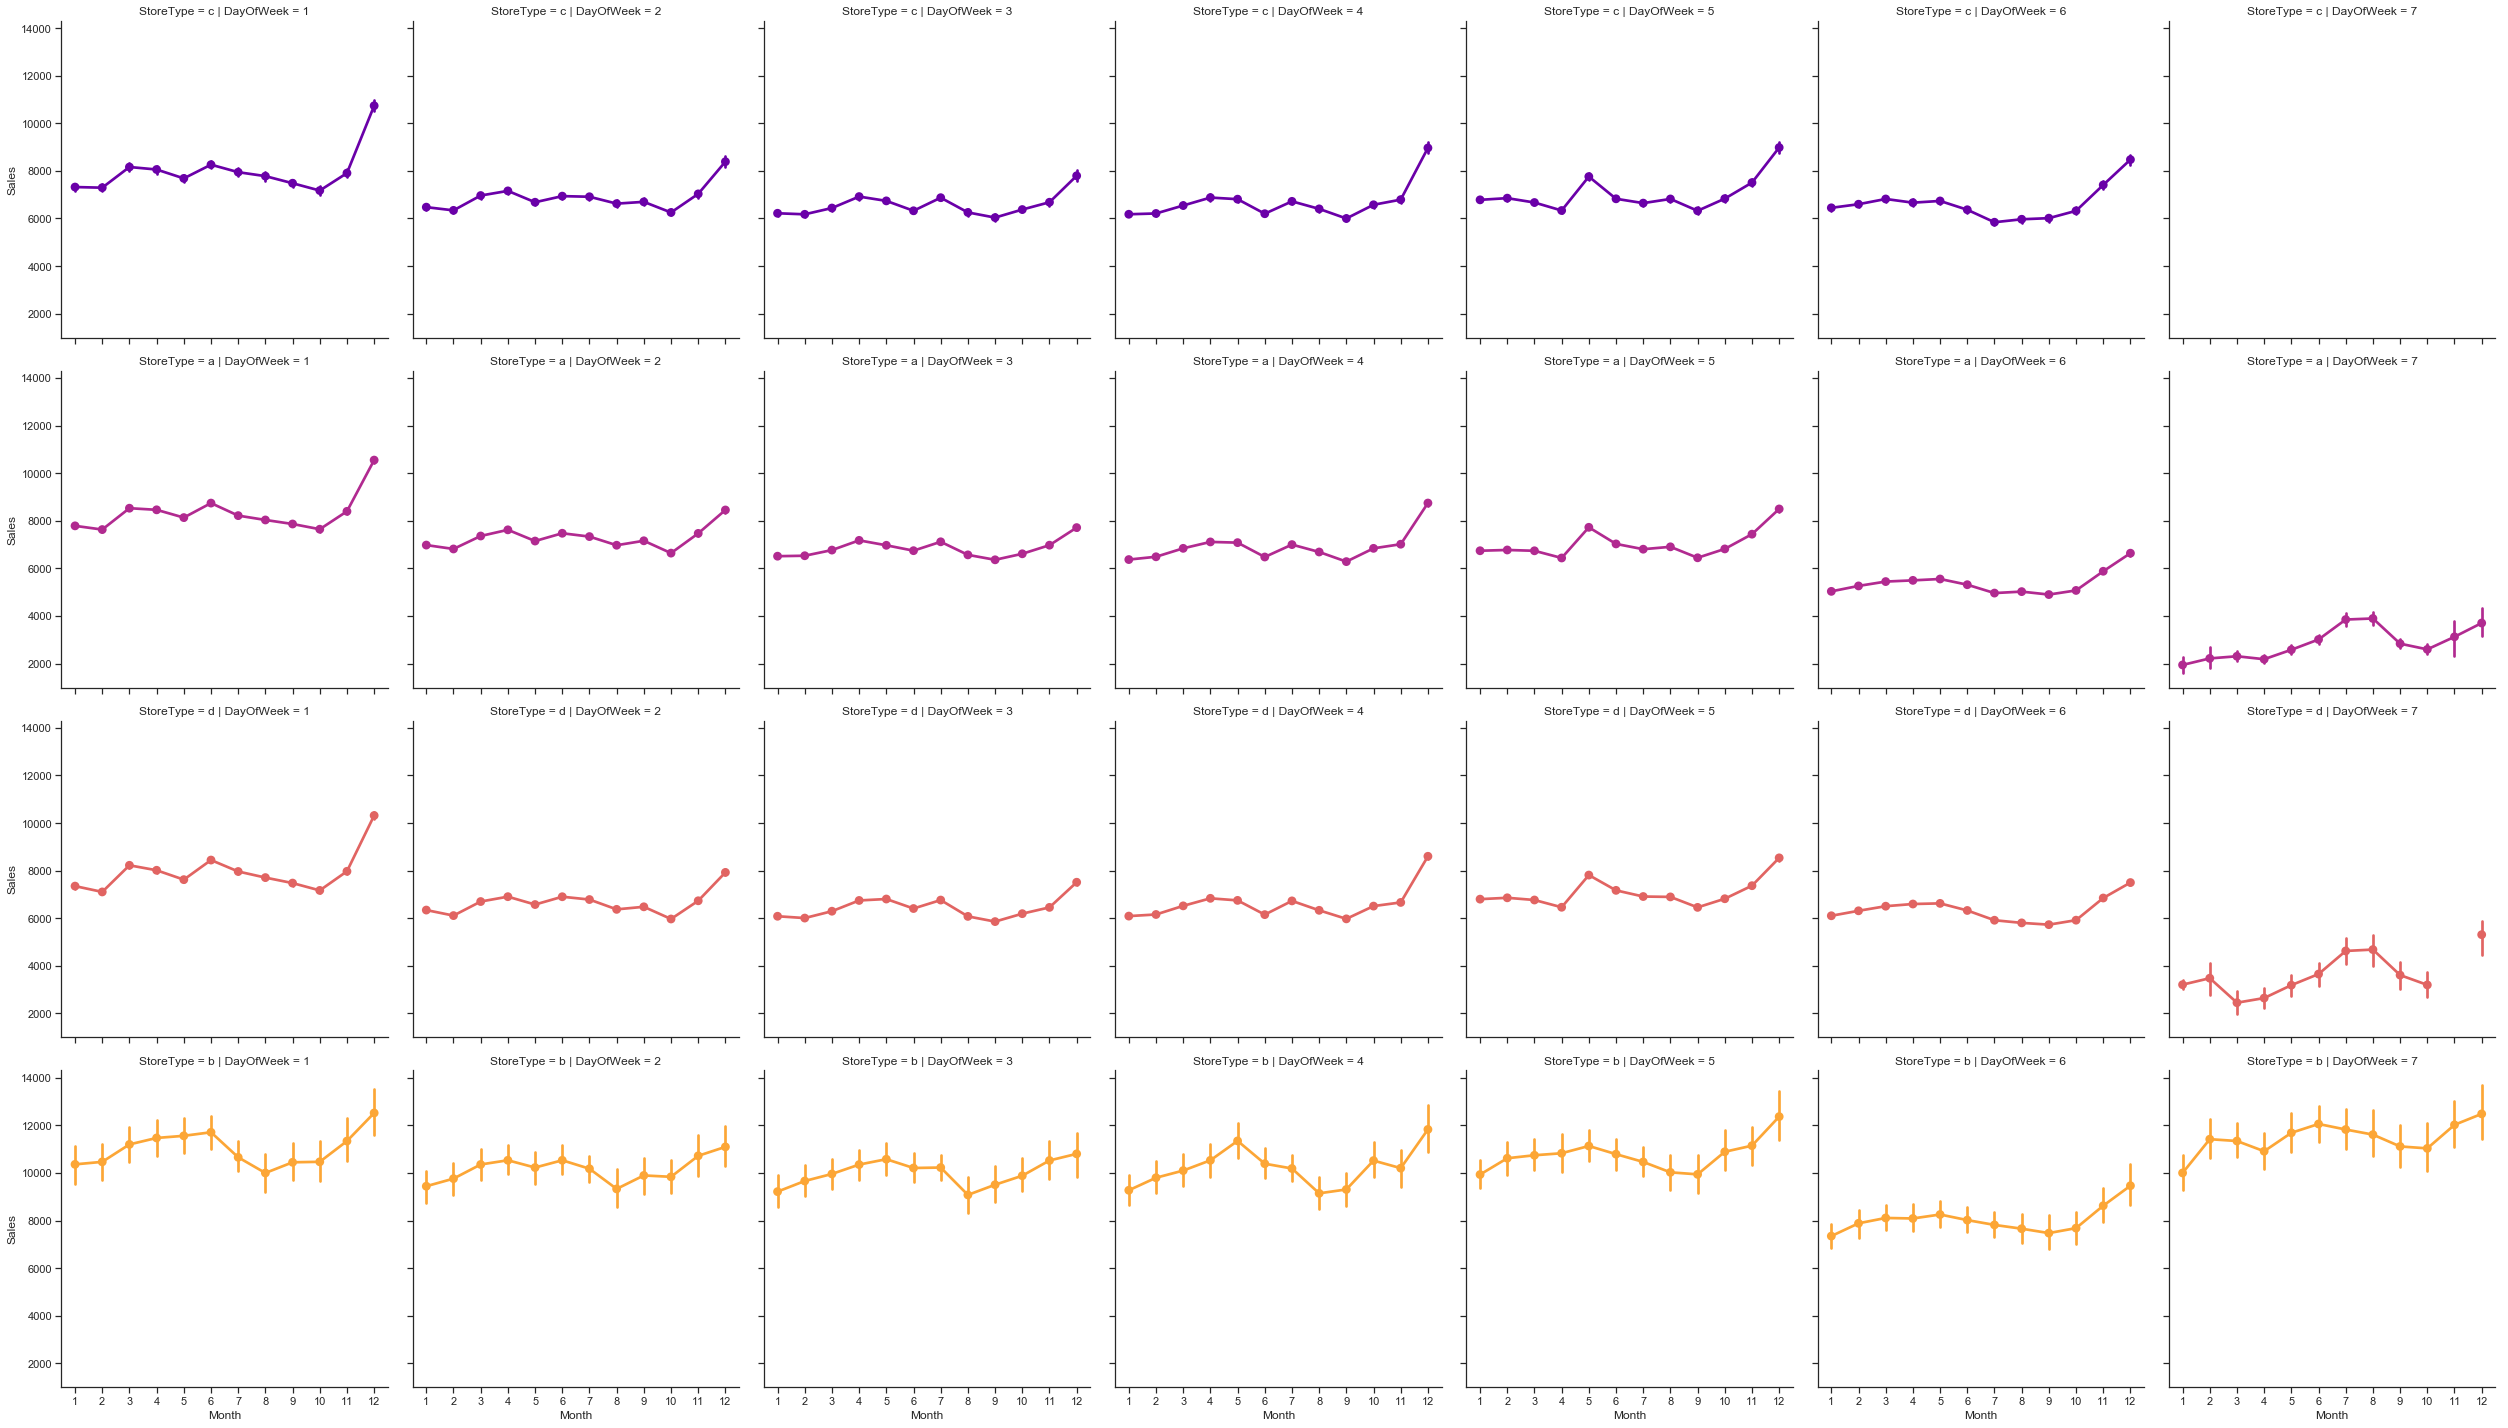

In [698]:
# sales and day of week
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c)

In [699]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers     PromoOpen  CompetitionOpen
StoreType                                                          
a           6926.197738   795.483849  12918.514431      7115.948162
b          10233.380141  2022.211825  17199.328069     11364.495244
c           6933.245148   815.546754  12158.430448      6745.937469
d           6822.448434   606.362984  10421.499136      9028.432981

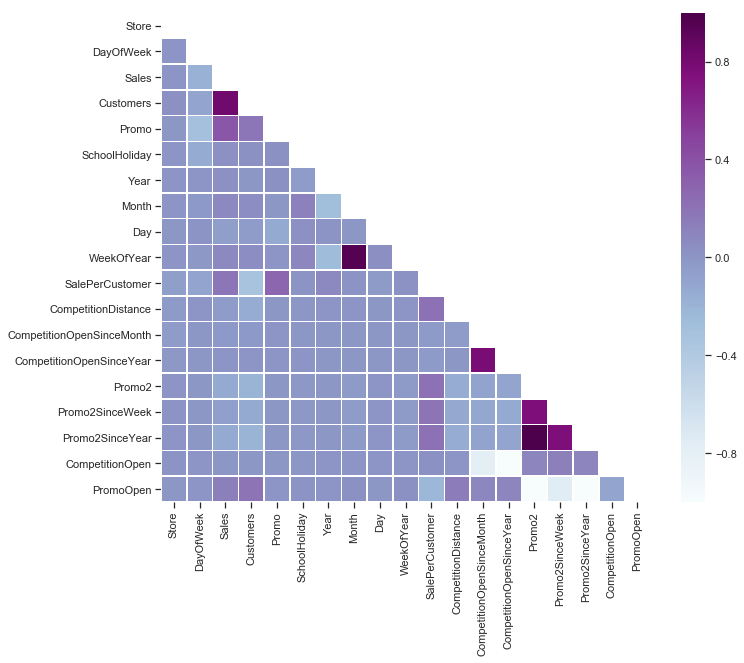

In [700]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()


In [701]:
columns_corr = ['Sales', 'Customers', 'Promo', 'Promo2','StateHoliday', 'SchoolHoliday','WeekOfYear','Month','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']
train_store[columns_corr].corr(method='pearson')

Sales  Customers     Promo    Promo2  \
Sales                     1.000000   0.823537  0.368160 -0.127568   
Customers                 0.823537   1.000000  0.182812 -0.202223   
Promo                     0.368160   0.182812  1.000000 -0.000339   
Promo2                   -0.127568  -0.202223 -0.000339  1.000000   
SchoolHoliday             0.038584   0.024867  0.028943 -0.008248   
WeekOfYear                0.074440   0.053743  0.006940 -0.024756   
Month                     0.073569   0.053826 -0.006421 -0.025823   
CompetitionOpenSinceYear  0.005290   0.001679  0.001011 -0.098553   
Promo2SinceWeek          -0.058504  -0.130876 -0.000819  0.759531   
Promo2SinceYear          -0.127593  -0.202196 -0.000341  0.999999   

                          SchoolHoliday  WeekOfYear     Month  \
Sales                          0.038584    0.074440  0.073569   
Customers                      0.024867    0.053743  0.053826   
Promo                          0.028943    0.006940 -0.006421   
Promo2                        -0.008248   -0.024756 -0.025823   
SchoolHoliday                  1.000000    0.079573  0.118462   
WeekOfYear                     0.079573    1.000000  0.960992   
Month                          0.118462    0.960992  1.000000   
CompetitionOpenSinceYear       0.000136   -0.000754 -0.000771   
Promo2SinceWeek               -0.008070   -0.030431 -0.031736   
Promo2SinceYear               -0.008251   -0.024761 -0.025828   

                          CompetitionOpenSinceYear  Promo2SinceWeek  \
Sales                                     0.005290        -0.058504   
Customers                                 0.001679        -0.130876   
Promo                                     0.001011        -0.000819   
Promo2                                   -0.098553         0.759531   
SchoolHoliday                             0.000136        -0.008070   
WeekOfYear                               -0.000754        -0.030431   
Month                                    -0.000771        -0.031736   
CompetitionOpenSinceYear                  1.000000        -0.125068   
Promo2SinceWeek                          -0.125068         1.000000   
Promo2SinceYear                          -0.098485         0.759345   

                          Promo2SinceYear  
Sales                           -0.127593  
Customers                       -0.202196  
Promo                           -0.000341  
Promo2                           0.999999  
SchoolHoliday                   -0.008251  
WeekOfYear                      -0.024761  
Month                           -0.025828  
CompetitionOpenSinceYear        -0.098485  
Promo2SinceWeek                  0.759345  
Promo2SinceYear                  1.000000

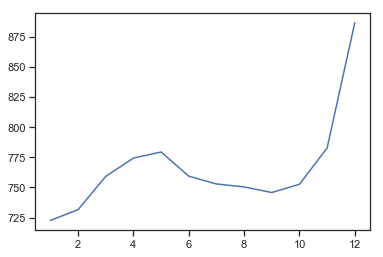

In [702]:
average_customers_per_month = train_store.groupby('Month')['Customers'].mean()
average_sales_per_month = train_store.groupby('Month')['Sales'].mean()
plt.figure(figsize=(6, 4))
plt.plot(average_customers_per_month)

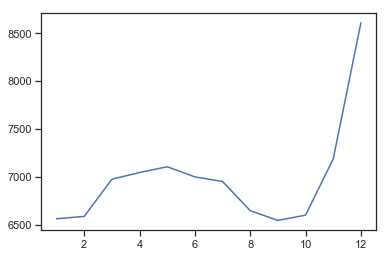

In [703]:
plt.plot(average_sales_per_month)

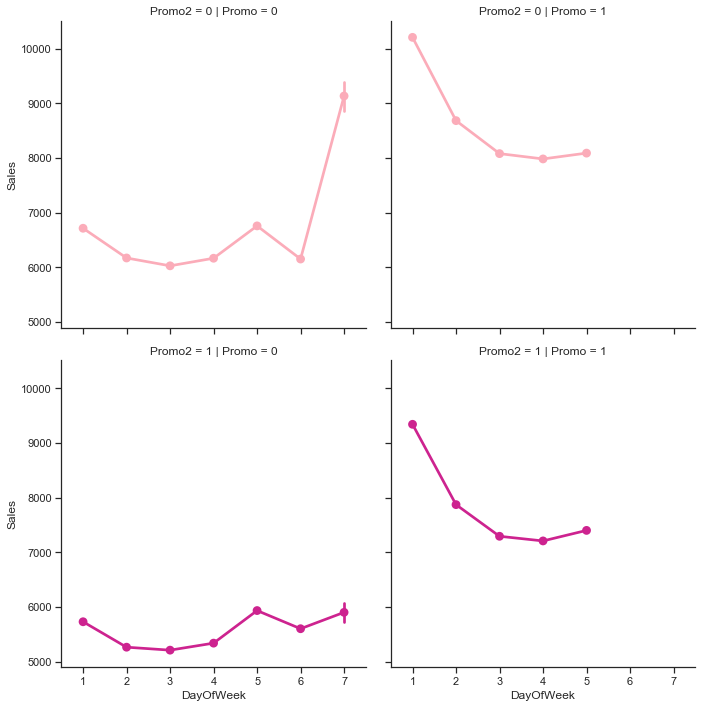

In [704]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

### Seasonality

In [868]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [706]:
sales_a.head()

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
Name: Sales, dtype: float64

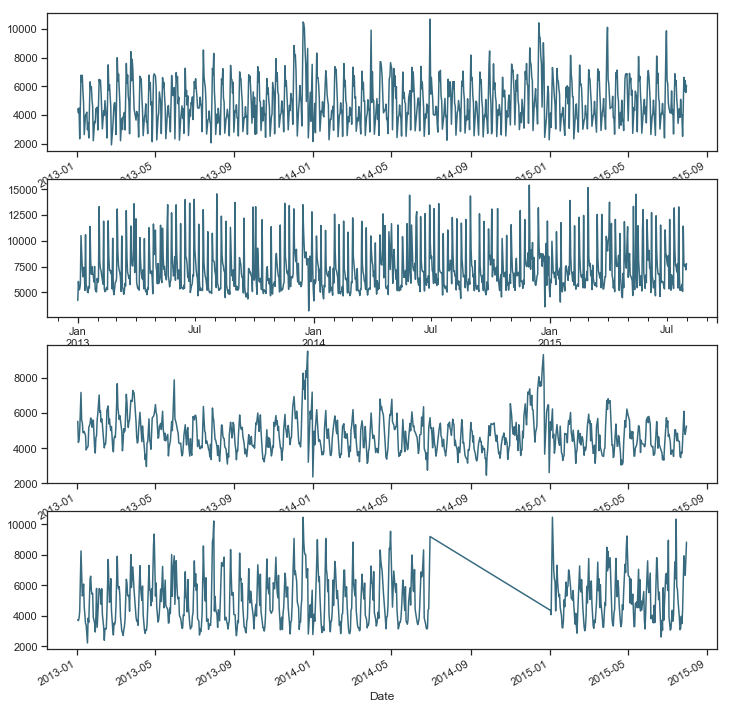

In [707]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
# store types
sales_a.plot(color = c, ax = ax1)
sales_b.plot(color = c, ax = ax2)
sales_c.plot(color = c, ax = ax3)
sales_d.plot(color = c, ax = ax4)

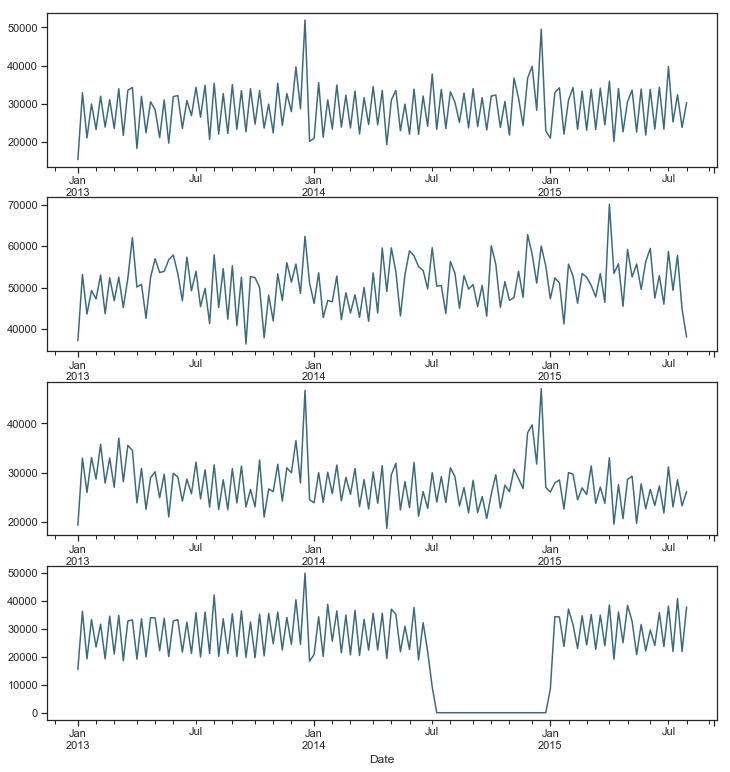

In [708]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
# store types
#resample by weeks
sales_a=sales_a.resample('W').sum()
sales_a.plot(color = c, ax = ax1)
sales_b=sales_b.resample('W').sum()
sales_b.plot(color = c, ax = ax2)
sales_c=sales_c.resample('W').sum()
sales_c.plot(color = c, ax = ax3)
sales_d=sales_d.resample('W').sum()
sales_d.plot(color = c, ax = ax4)

In [709]:
# resample info
# https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8

## Prediction with fbprophet

In [866]:
sales_a = train[train.Store == 2]


AttributeError: 'numpy.ndarray' object has no attribute 'Store'

In [867]:
sales_a.head()

Sales
Date              
2015-07-31  6064.0
2015-07-30  5567.0
2015-07-29  6402.0
2015-07-28  5671.0
2015-07-27  6627.0

In [713]:
#sales_a=sales_a.resample('W').sum()

In [714]:
df=sales_a
#df.reset_index(inplace=True)
df=df.rename(columns={'Date':'ds', 'Sales':'y'})
df.head()

Store  DayOfWeek       y  Customers  Open  Promo StateHoliday  \
Date                                                                        
2015-07-31      2          5  6064.0        625     1      1            0   
2015-07-30      2          4  5567.0        601     1      1            0   
2015-07-29      2          3  6402.0        727     1      1            0   
2015-07-28      2          2  5671.0        646     1      1            0   
2015-07-27      2          1  6627.0        638     1      1            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear         ds  \
Date                                                                 
2015-07-31              1  2015      7   31          31 2015-07-31   
2015-07-30              1  2015      7   30          31 2015-07-30   
2015-07-29              1  2015      7   29          31 2015-07-29   
2015-07-28              1  2015      7   28          31 2015-07-28   
2015-07-27              1  2015      7   27          31 2015-07-27   

            SalePerCustomer  
Date                         
2015-07-31         9.702400  
2015-07-30         9.262895  
2015-07-29         8.806052  
2015-07-28         8.778638  
2015-07-27        10.387147

In [715]:
import fbprophet
df_prophet=fbprophet.Prophet(changepoint_prior_scale=0.50)
df_prophet.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [716]:
df_forecast=df_prophet.make_future_dataframe(periods=30,freq='W')
df_forecast=df_prophet.predict(df_forecast)

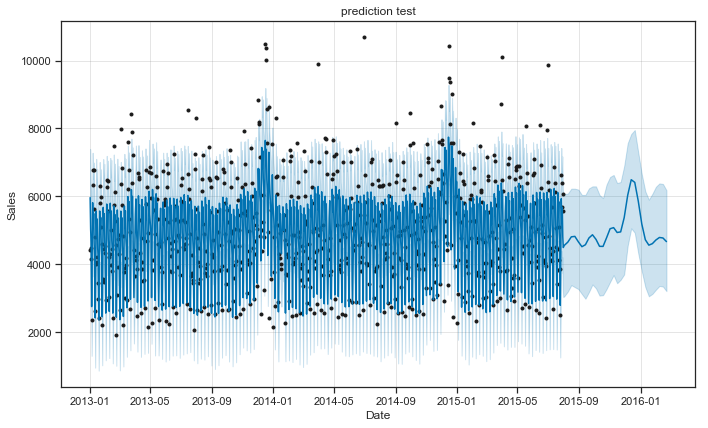

In [717]:
df_prophet.plot(df_forecast,xlabel='Date',ylabel='Sales')
plt.title('prediction test');

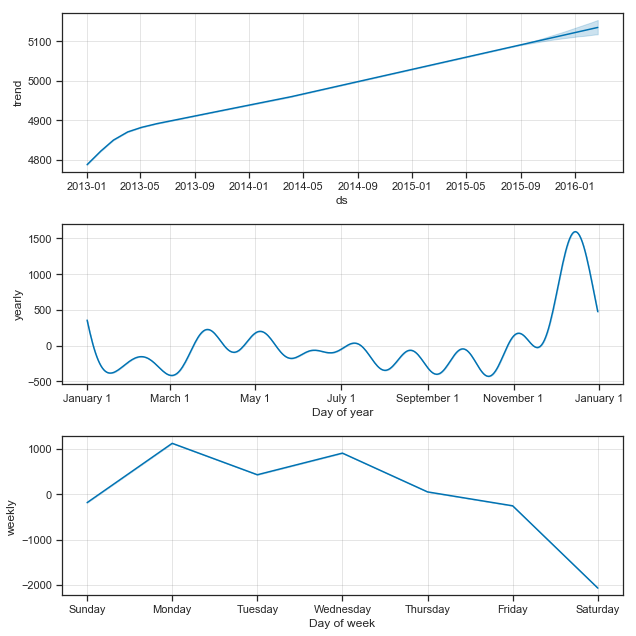

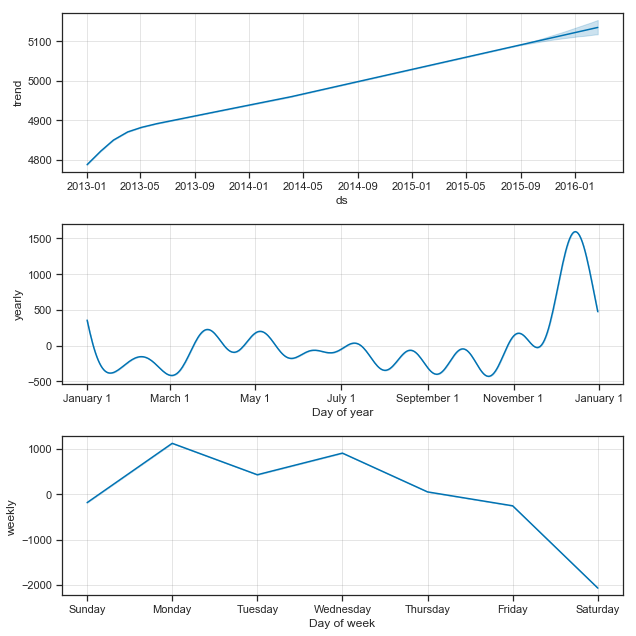

In [718]:
df_prophet.plot_components(df_forecast)

## LSTM 

In [869]:
df2=train.loc[:,['Sales']]
#df2=df2.set_index(tran.index)
df2.head()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [870]:
df2.shape

(844179, 1)

In [722]:
#normalizing data / rescale to the range of 0-1 or -1-1
from sklearn.preprocessing import MinMaxScaler
values=df2['Sales'].values.reshape(-1,1)
values=values.astype('float32')
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

In [723]:
scaled

array([[0.12569569],
       [0.14499457],
       [0.1992049 ],
       ...,
       [0.12020238],
       [0.10709552],
       [0.14251295]], dtype=float32)

In [724]:
#split to train and test 80/20
train_size=int(len(scaled)*0.8)
test_size=len(scaled)-train_size
train, test=scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

675343 168836


In [725]:
def create_dataset(dataset, look_back=1):
    dataX, dataY=[], []
    for i in range(len(dataset) - look_back):
        a = dataset[i: (i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [726]:
look_back=2
trainX, trainY= create_dataset(train, look_back)
testX, testY=create_dataset(test, look_back)

675341
168834


In [727]:
#The LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features].

In [728]:
trainX.shape

(675341, 2)

In [729]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [730]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model=Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history=model.fit(trainX, trainY, epochs=50, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False)

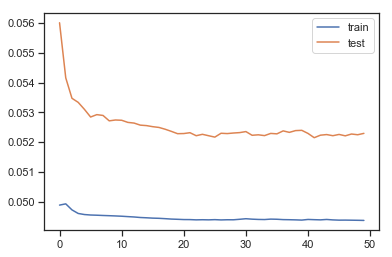

In [731]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [732]:
#clustering

In [733]:
train_store.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month    ...      Assortment  CompetitionDistance  \
0              1  2015      7    ...               a               1270.0   
1              1  2015      7    ...               a               1270.0   
2              1  2015      7    ...               a               1270.0   
3              1  2015      7    ...               a               1270.0   
4              1  2015      7    ...               a               1270.0   

  CompetitionOpenSinceMonth  CompetitionOpenSinceYear Promo2 Promo2SinceWeek  \
0                       9.0                    2008.0      0             0.0   
1                       9.0                    2008.0      0             0.0   
2                       9.0                    2008.0      0             0.0   
3                       9.0                    2008.0      0             0.0   
4                       9.0                    2008.0      0             0.0   

   Promo2SinceYear  PromoInterval  CompetitionOpen  PromoOpen  
0              0.0              0             82.0   24187.75  
1              0.0              0             82.0   24187.75  
2              0.0              0             82.0   24187.75  
3              0.0              0             82.0   24187.75  
4              0.0              0             82.0   24187.75  

[5 rows x 25 columns]

In [734]:
train_store.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month    ...      Assortment  CompetitionDistance  \
0              1  2015      7    ...               a               1270.0   
1              1  2015      7    ...               a               1270.0   
2              1  2015      7    ...               a               1270.0   
3              1  2015      7    ...               a               1270.0   
4              1  2015      7    ...               a               1270.0   

  CompetitionOpenSinceMonth  CompetitionOpenSinceYear Promo2 Promo2SinceWeek  \
0                       9.0                    2008.0      0             0.0   
1                       9.0                    2008.0      0             0.0   
2                       9.0                    2008.0      0             0.0   
3                       9.0                    2008.0      0             0.0   
4                       9.0                    2008.0      0             0.0   

   Promo2SinceYear  PromoInterval  CompetitionOpen  PromoOpen  
0              0.0              0             82.0   24187.75  
1              0.0              0             82.0   24187.75  
2              0.0              0             82.0   24187.75  
3              0.0              0             82.0   24187.75  
4              0.0              0             82.0   24187.75  

[5 rows x 25 columns]

In [735]:
train_store['Date']=pd.to_datetime(train_store['Date'])
train_store['dy']=train_store['Date'].dt.dayofyear
#train_store['hours']=train_store['Date'].dt.time
data_2014=train_store.loc[:,['Sales']]
temp=train_store.loc[:,['dy','Sales']]
data_2014['Sales']=pd.to_numeric(data_2014['Sales'],errors='coerce')
#temp=temp.set_index(data_2014.hours)
#temp=data_2014.pivot_Table(index=['hours'], columns=['dy'], values=['Sales'],fill_value=0)
temp.head()

dy  Sales
0  212   5263
1  211   5020
2  210   4782
3  209   5011
4  208   6102

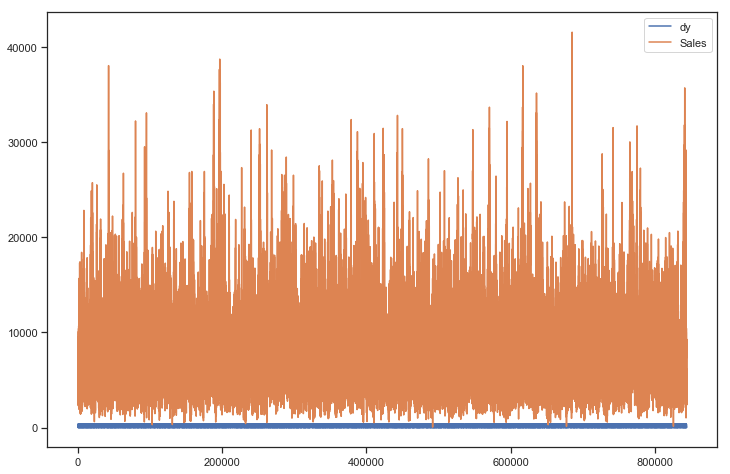

In [736]:
temp.plot(figsize=(12,8))

In [737]:
#second try
#https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

In [738]:
sales_a=sales_a[sales_a.Year == 2015]


In [739]:
sales_a=sales_a.loc[:,['Sales']]

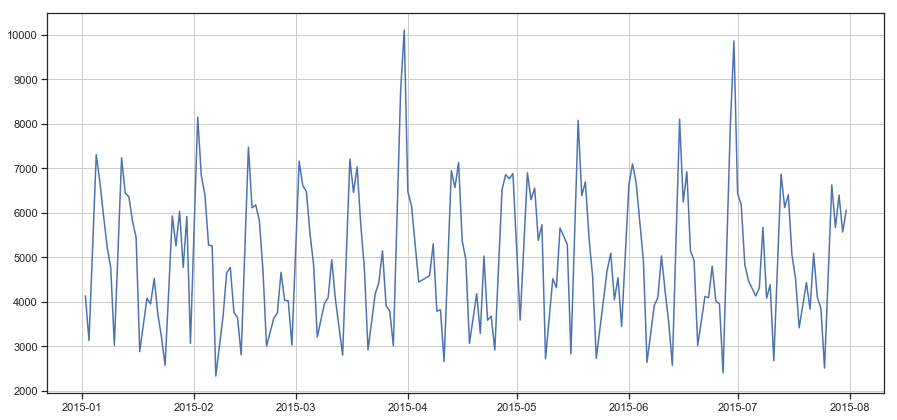

In [740]:
plt.figure(figsize=(15, 7))
plt.plot(sales_a.Sales)
plt.grid(True)
plt.show()


In [741]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [871]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series.iloc[-n:])

moving_average(sales_a['Sales'], 3)

4859.0

In [743]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(18,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [744]:
mpl.rcParams['agg.path.chunksize'] = 10000

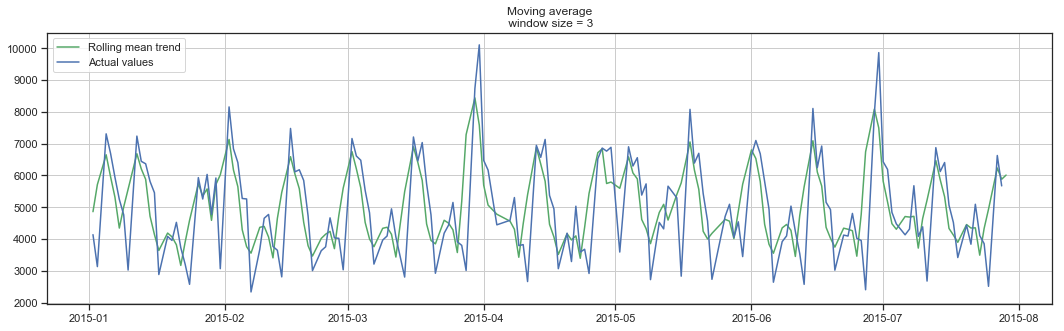

In [745]:
plotMovingAverage(sales_a['Sales'], 3)

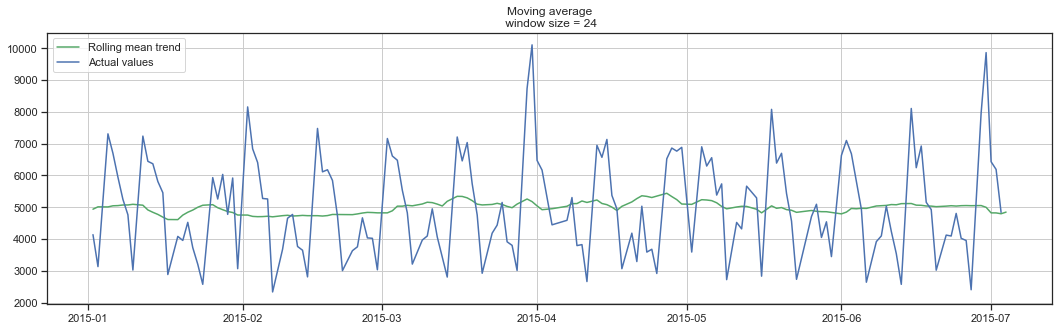

In [872]:
plotMovingAverage(sales_a['Sales'], 24)

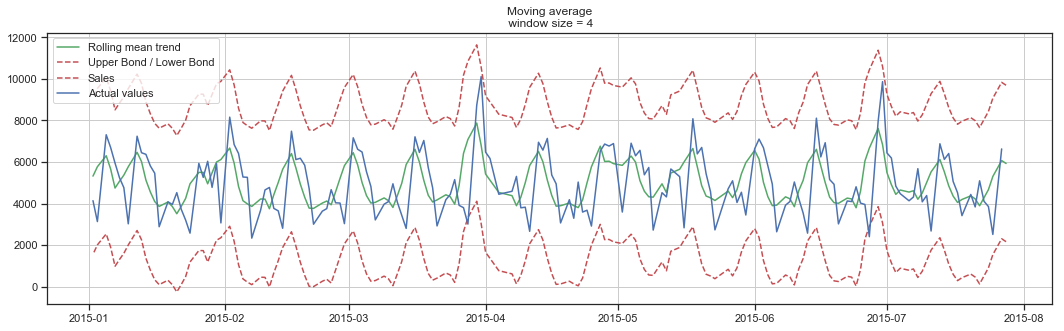

In [747]:
plotMovingAverage(sales_a['Sales'], 4, plot_intervals=True)

In [748]:
sales_anomaly = sales_a.copy()
sales_anomaly.iloc[-20] = sales_anomaly.iloc[-20] * 0.2 # say we have 80% drop of sales

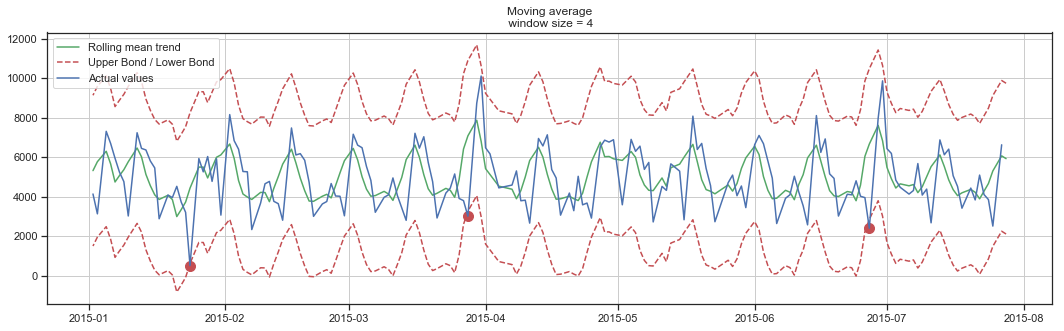

In [749]:
plotMovingAverage(sales_anomaly, 4, plot_intervals=True, plot_anomalies=True)



In [750]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)


In [751]:
  weighted_average(sales_a['Sales'], [0.6, 0.3, 0.1])

5738.1

## exponential smoothing

In [752]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

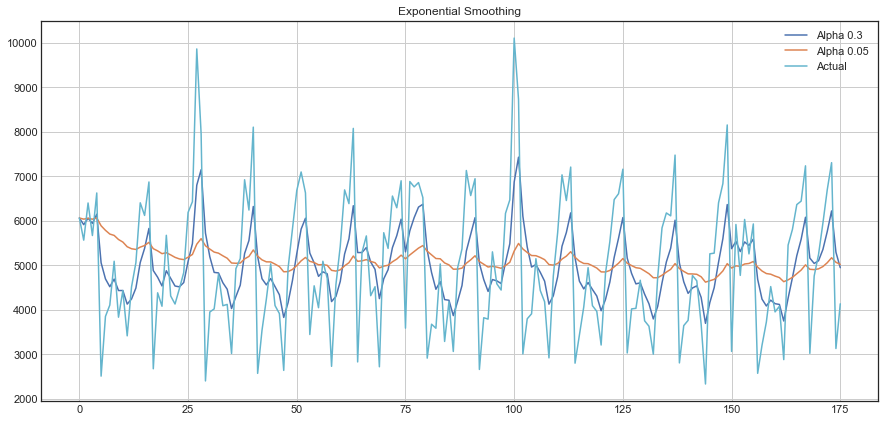

In [753]:
plotExponentialSmoothing(sales_a['Sales'], [0.3, 0.05])


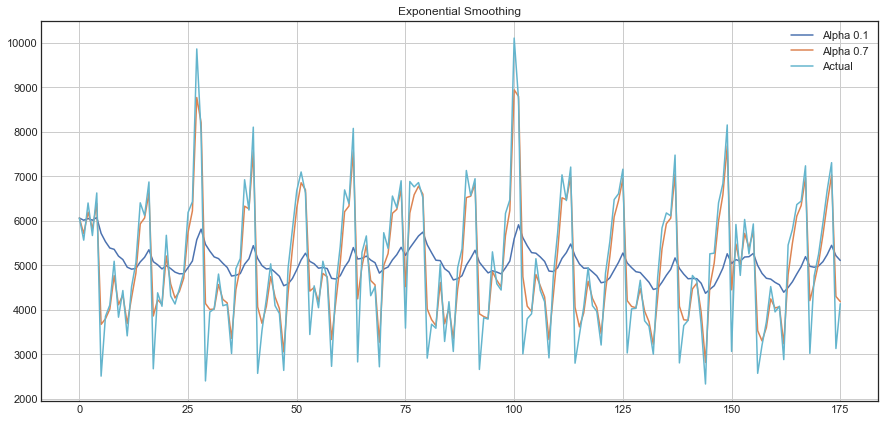

In [759]:
plotExponentialSmoothing(sales_a['Sales'], [0.1, 0.7])

## Double exponential smoothing

In [760]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        

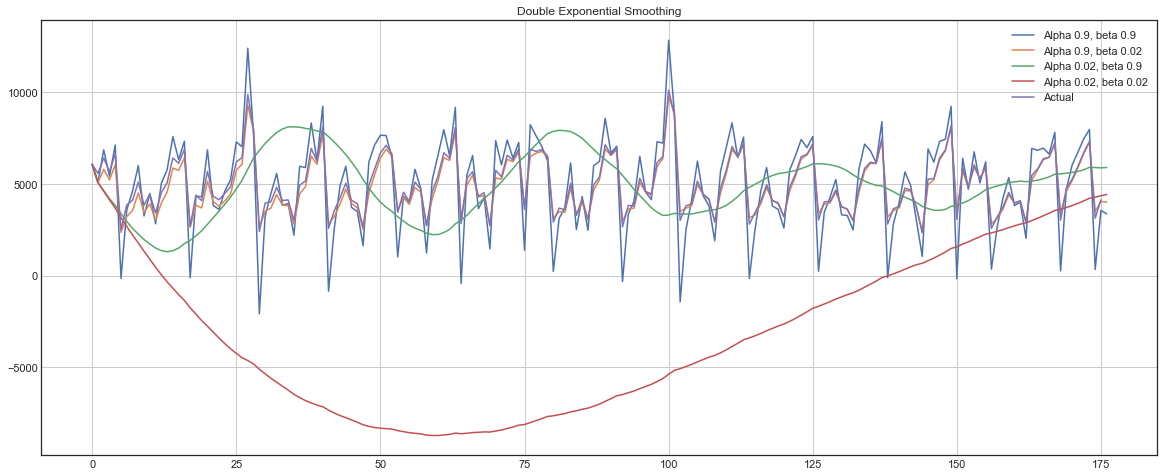

In [761]:
  plotDoubleExponentialSmoothing(sales_a['Sales'], alphas=[0.9, 0.02], betas=[0.9, 0.02])


## Triple exponential smoothing / Holt-Winters

In [762]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### How to estimate model parameters automatically?

In [846]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=16):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [997]:
%%time
data = sales_a['Sales'][:-10] # leave some data for testing



Wall time: 500 µs


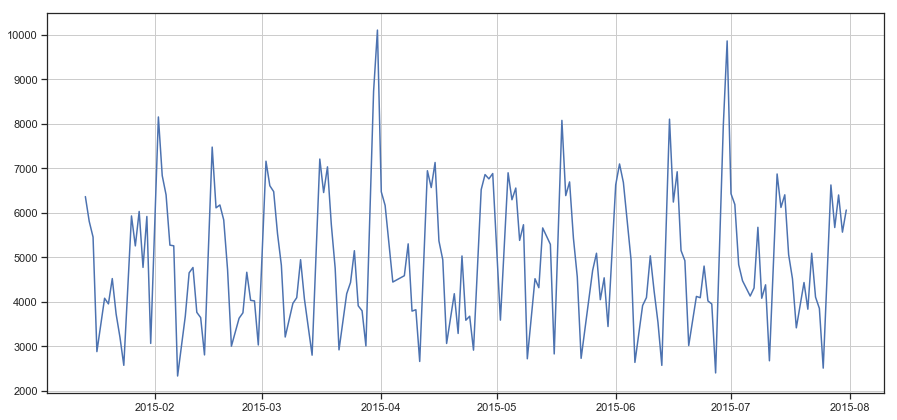

In [998]:
plt.figure(figsize=(15, 7))
plt.plot(data)
plt.grid(True)
plt.show()


In [849]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 


In [850]:

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )



In [851]:
# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


0.019888807711630208 0.02890905005879063 0.10046668728813474


In [861]:

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 2)
model.triple_exponential_smoothing()

In [862]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

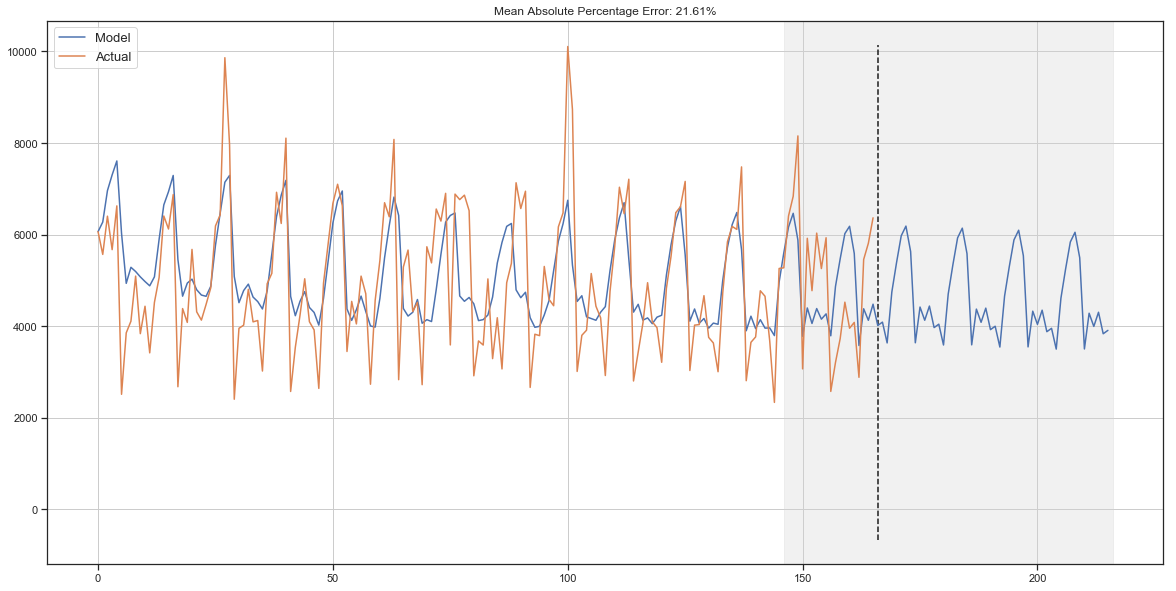

In [863]:
plotHoltWinters(data)

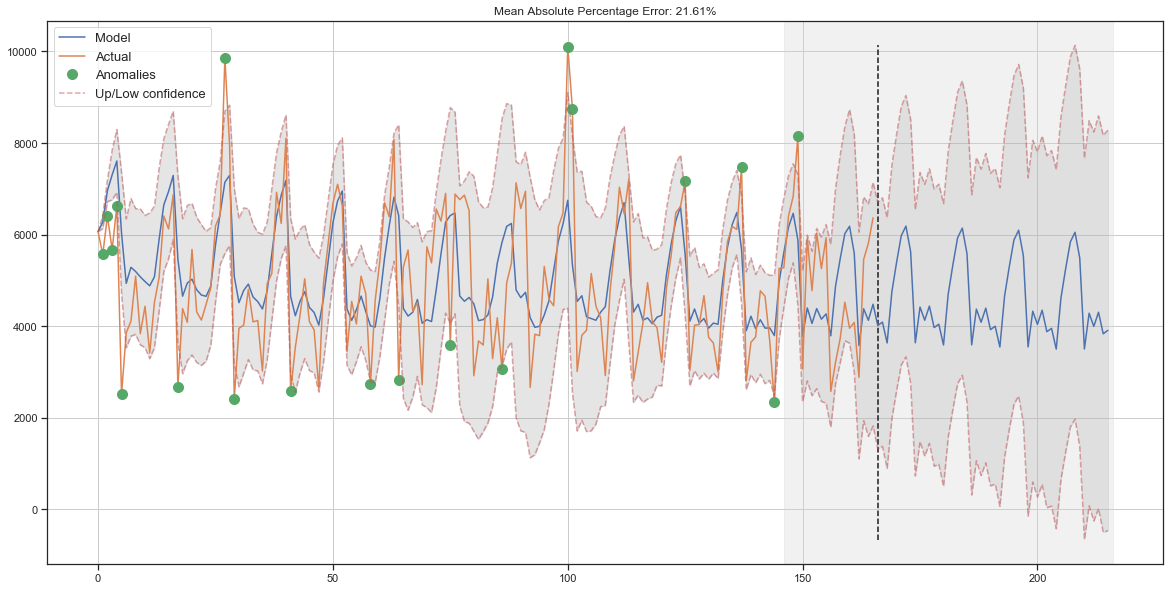

In [864]:
plotHoltWinters(data, plot_intervals=True, plot_anomalies=True)

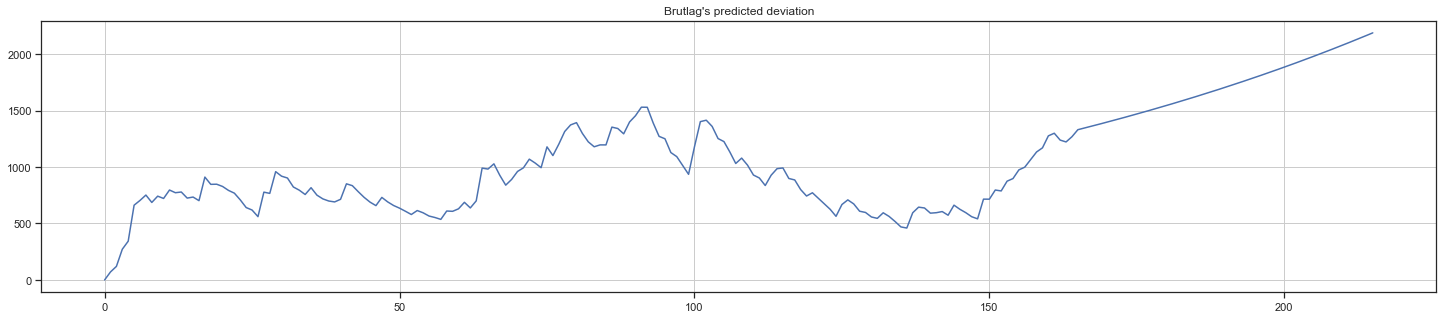

In [865]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## Stationarity

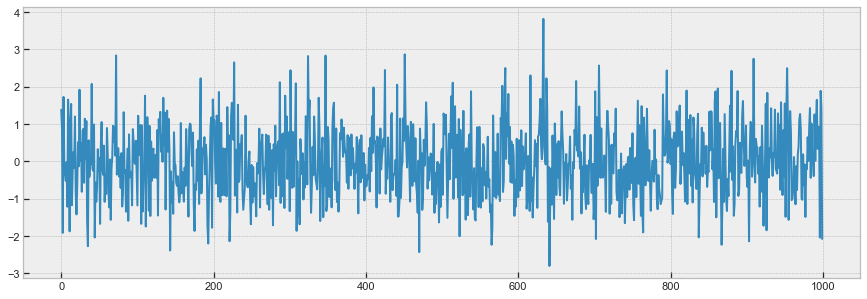

In [873]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

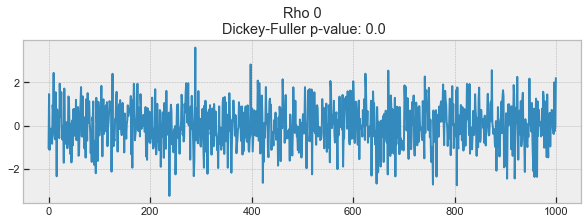

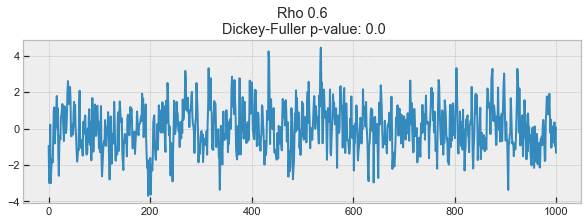

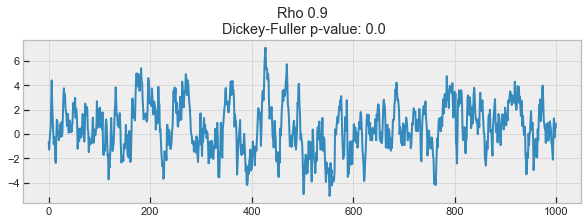

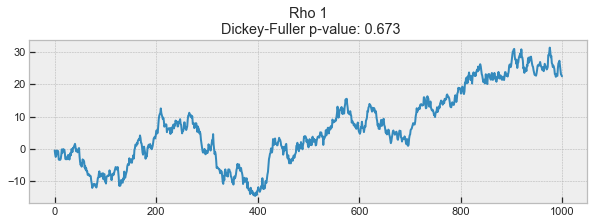

In [886]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

## SARIMA

In [893]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

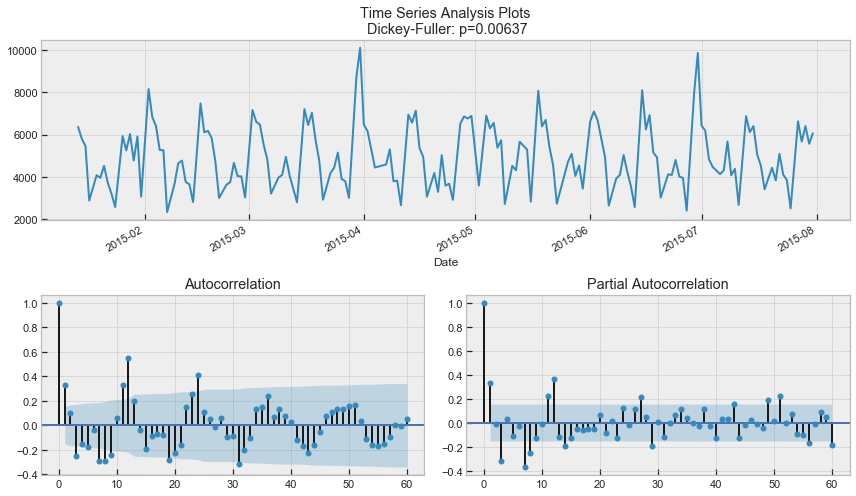

In [894]:
tsplot(data, lags=60)

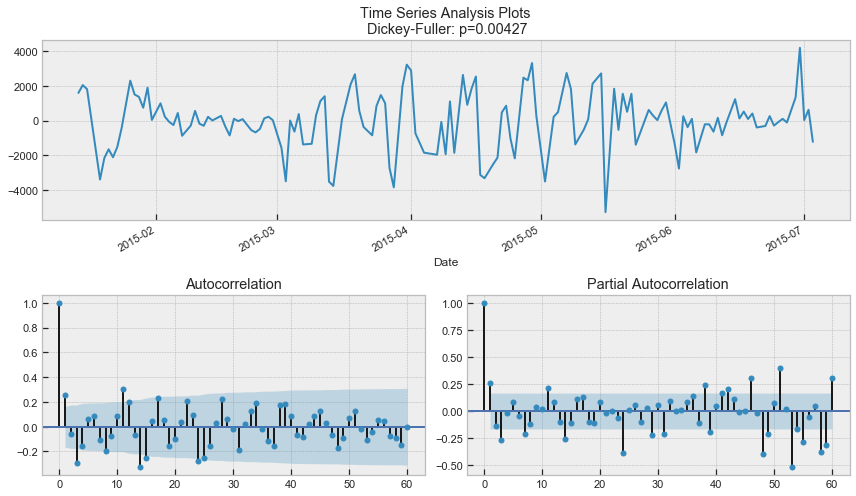

In [897]:
data_diff = data - data.shift(24)
tsplot(data_diff[24:], lags=60)

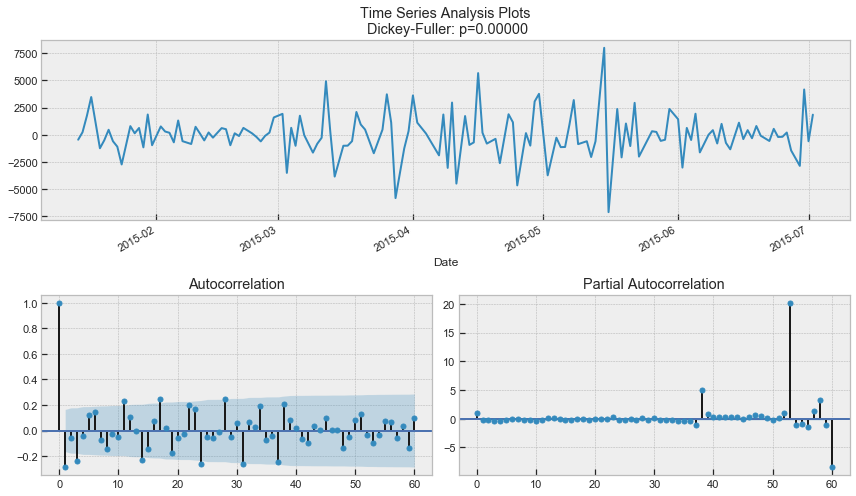

In [898]:
data_diff = data_diff - data_diff.shift(1)
tsplot(data_diff[24+1:], lags=60)

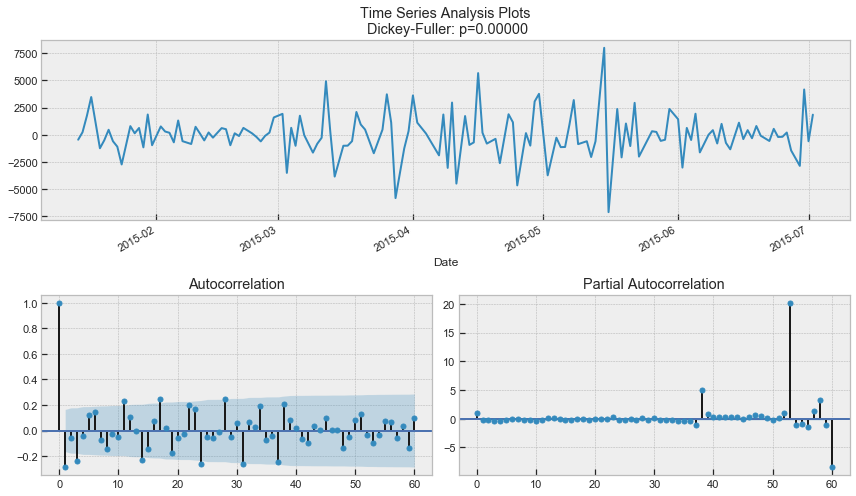

In [900]:
tsplot(data_diff[24+1:], lags=60)

In [975]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 # season length is still 24

from itertools import product
# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [989]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [986]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda3\lib\site-pac


Wall time: 30.5 s


In [987]:
result_table.head()

parameters          aic
0  (3, 2, 1, 1)  2637.953237
1  (3, 2, 0, 1)  2637.953237
2  (2, 3, 0, 1)  2639.885625
3  (2, 3, 1, 1)  2639.885625
4  (2, 2, 0, 1)  2642.970398

In [988]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  166
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -1310.977
Date:                            Mon, 22 Oct 2018   AIC                           2637.953
Time:                                    11:20:32   BIC                           2662.197
Sample:                                         0   HQIC                          2647.801
                                            - 166                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0020      0.329     -0.006      0.995      -0.648       0.643
ar.L2          0.1140      0.081   

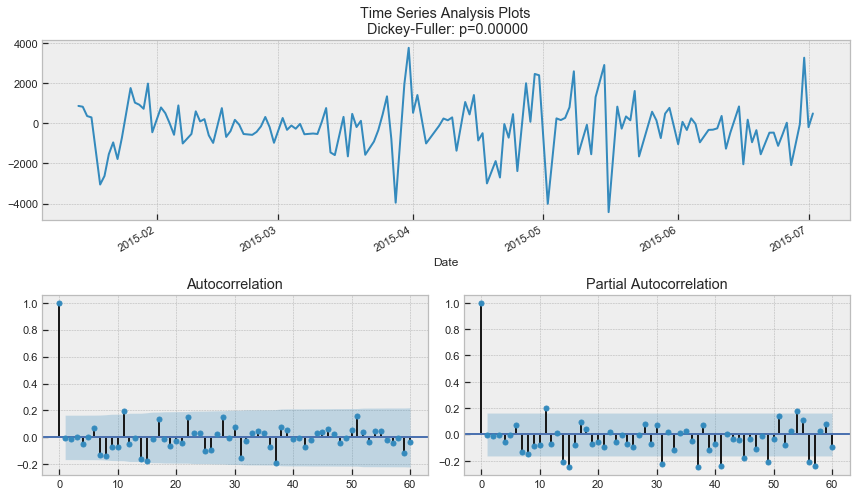

In [990]:
tsplot(best_model.resid[24+1:], lags=60)

In [991]:
# residuals are stationary, and there are no apparent autocorrelations

In [1234]:
 # adding model values
model_data = data.copy()



In [1235]:
model_data

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
2015-07-25    2512.0
2015-07-24    3854.0
2015-07-23    4108.0
2015-07-22    5093.0
2015-07-21    3836.0
2015-07-20    4435.0
2015-07-18    3417.0
2015-07-17    4518.0
2015-07-16    5062.0
2015-07-15    6406.0
2015-07-14    6122.0
2015-07-13    6874.0
2015-07-11    2677.0
2015-07-10    4384.0
2015-07-09    4082.0
2015-07-08    5676.0
2015-07-07    4313.0
2015-07-06    4132.0
2015-07-04    4475.0
2015-07-03    4838.0
2015-07-02    6189.0
2015-07-01    6431.0
2015-06-30    9863.0
2015-06-29    7961.0
2015-06-27    2404.0
               ...  
2015-02-17    6113.0
2015-02-16    7478.0
2015-02-14    2809.0
2015-02-13    3647.0
2015-02-12    3765.0
2015-02-11    4773.0
2015-02-10    4653.0
2015-02-09    3678.0
2015-02-07    2335.0
2015-02-06    5260.0
2015-02-05    5275.0
2015-02-04    6405.0
2015-02-03    6837.0
2015-02-02    8155.0
2015-01-31    3067.0
2015-01-30    5919.0
2015-01-

In [1236]:
model_data.columns = ['Sales']



In [1237]:
model_data

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
2015-07-25    2512.0
2015-07-24    3854.0
2015-07-23    4108.0
2015-07-22    5093.0
2015-07-21    3836.0
2015-07-20    4435.0
2015-07-18    3417.0
2015-07-17    4518.0
2015-07-16    5062.0
2015-07-15    6406.0
2015-07-14    6122.0
2015-07-13    6874.0
2015-07-11    2677.0
2015-07-10    4384.0
2015-07-09    4082.0
2015-07-08    5676.0
2015-07-07    4313.0
2015-07-06    4132.0
2015-07-04    4475.0
2015-07-03    4838.0
2015-07-02    6189.0
2015-07-01    6431.0
2015-06-30    9863.0
2015-06-29    7961.0
2015-06-27    2404.0
               ...  
2015-02-17    6113.0
2015-02-16    7478.0
2015-02-14    2809.0
2015-02-13    3647.0
2015-02-12    3765.0
2015-02-11    4773.0
2015-02-10    4653.0
2015-02-09    3678.0
2015-02-07    2335.0
2015-02-06    5260.0
2015-02-05    5275.0
2015-02-04    6405.0
2015-02-03    6837.0
2015-02-02    8155.0
2015-01-31    3067.0
2015-01-30    5919.0
2015-01-

In [1239]:
model_data2= model.fittedvalues


In [1242]:
model_data = pd.concat([model_data, model_data2], axis=1, join='inner')

In [1244]:
model_data.columns=['Sales','arima_model']

In [1245]:
model_data

Sales  arima_model
Date                           
2015-07-31  6064.0          NaN
2015-07-30  5567.0          NaN
2015-07-29  6402.0          NaN
2015-07-28  5671.0          NaN
2015-07-27  6627.0          NaN
2015-07-25  2512.0          NaN
2015-07-24  3854.0          NaN
2015-07-23  4108.0          NaN
2015-07-22  5093.0          NaN
2015-07-21  3836.0          NaN
2015-07-20  4435.0          NaN
2015-07-18  3417.0          NaN
2015-07-17  4518.0          NaN
2015-07-16  5062.0  5974.638281
2015-07-15  6406.0  6157.760034
2015-07-14  6122.0  6705.329063
2015-07-13  6874.0  6488.463456
2015-07-11  2677.0  4108.497770
2015-07-10  4384.0  4026.602988
2015-07-09  4082.0  4719.088069
2015-07-08  5676.0  5114.117143
2015-07-07  4313.0  4355.890325
2015-07-06  4132.0  4775.070633
2015-07-04  4475.0  3632.805428
2015-07-03  4838.0  5801.958553
2015-07-02  6189.0  5692.067356
2015-07-01  6431.0  6797.461128
2015-06-30  9863.0  6640.627452
2015-06-29  7961.0  8050.645104
2015-06-27  2404.0  4426.843822
...            ...          ...
2015-02-17  6113.0  6728.712045
2015-02-16  7478.0  6769.650216
2015-02-14  2809.0  3610.097275
2015-02-13  3647.0  4054.305901
2015-02-12  3765.0  3629.938288
2015-02-11  4773.0  4624.284607
2015-02-10  4653.0  3889.342090
2015-02-09  3678.0  4100.094494
2015-02-07  2335.0  3251.318284
2015-02-06  5260.0  4334.745762
2015-02-05  5275.0  5930.197682
2015-02-04  6405.0  6147.249267
2015-02-03  6837.0  6301.659972
2015-02-02  8155.0  7461.546054
2015-01-31  3067.0  3331.255354
2015-01-30  5919.0  3848.972784
2015-01-29  4775.0  4260.810342
2015-01-28  6032.0  5063.765603
2015-01-27  5258.0  4522.988744
2015-01-26  5931.0  4175.718589
2015-01-24  2575.0  3368.231271
2015-01-23  3206.0  5064.939989
2015-01-22  3728.0  4889.029325
2015-01-21  4524.0  5897.031717
2015-01-20  3955.0  6573.296403
2015-01-19  4082.0  6820.267365
2015-01-17  2883.0  2460.829056
2015-01-16  5456.0  4848.182249
2015-01-15  5810.0  4921.776275
2015-01-14  6366.0  5353.094411

[166 rows x 2 columns]

In [1246]:
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
model_data['arima_model'][:s+d] = np.NaN

In [1247]:
model_data

Sales  arima_model
Date                           
2015-07-31  6064.0          NaN
2015-07-30  5567.0          NaN
2015-07-29  6402.0          NaN
2015-07-28  5671.0          NaN
2015-07-27  6627.0          NaN
2015-07-25  2512.0          NaN
2015-07-24  3854.0          NaN
2015-07-23  4108.0          NaN
2015-07-22  5093.0          NaN
2015-07-21  3836.0          NaN
2015-07-20  4435.0          NaN
2015-07-18  3417.0          NaN
2015-07-17  4518.0          NaN
2015-07-16  5062.0  5974.638281
2015-07-15  6406.0  6157.760034
2015-07-14  6122.0  6705.329063
2015-07-13  6874.0  6488.463456
2015-07-11  2677.0  4108.497770
2015-07-10  4384.0  4026.602988
2015-07-09  4082.0  4719.088069
2015-07-08  5676.0  5114.117143
2015-07-07  4313.0  4355.890325
2015-07-06  4132.0  4775.070633
2015-07-04  4475.0  3632.805428
2015-07-03  4838.0  5801.958553
2015-07-02  6189.0  5692.067356
2015-07-01  6431.0  6797.461128
2015-06-30  9863.0  6640.627452
2015-06-29  7961.0  8050.645104
2015-06-27  2404.0  4426.843822
...            ...          ...
2015-02-17  6113.0  6728.712045
2015-02-16  7478.0  6769.650216
2015-02-14  2809.0  3610.097275
2015-02-13  3647.0  4054.305901
2015-02-12  3765.0  3629.938288
2015-02-11  4773.0  4624.284607
2015-02-10  4653.0  3889.342090
2015-02-09  3678.0  4100.094494
2015-02-07  2335.0  3251.318284
2015-02-06  5260.0  4334.745762
2015-02-05  5275.0  5930.197682
2015-02-04  6405.0  6147.249267
2015-02-03  6837.0  6301.659972
2015-02-02  8155.0  7461.546054
2015-01-31  3067.0  3331.255354
2015-01-30  5919.0  3848.972784
2015-01-29  4775.0  4260.810342
2015-01-28  6032.0  5063.765603
2015-01-27  5258.0  4522.988744
2015-01-26  5931.0  4175.718589
2015-01-24  2575.0  3368.231271
2015-01-23  3206.0  5064.939989
2015-01-22  3728.0  4889.029325
2015-01-21  4524.0  5897.031717
2015-01-20  3955.0  6573.296403
2015-01-19  4082.0  6820.267365
2015-01-17  2883.0  2460.829056
2015-01-16  5456.0  4848.182249
2015-01-15  5810.0  4921.776275
2015-01-14  6366.0  5353.094411

[166 rows x 2 columns]

In [1248]:
    # forecasting on n_steps forward 
forecast = model.predict(start = model_data.shape[0], end = model_data.shape[0]+50)
forecast = model_data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
error = mean_absolute_percentage_error(model_data.values[s+d], model_data['arima_model'][s+d])

In [1266]:
forecast

2015-07-31 00:00:00            NaN
2015-07-30 00:00:00            NaN
2015-07-29 00:00:00            NaN
2015-07-28 00:00:00            NaN
2015-07-27 00:00:00            NaN
2015-07-25 00:00:00            NaN
2015-07-24 00:00:00            NaN
2015-07-23 00:00:00            NaN
2015-07-22 00:00:00            NaN
2015-07-21 00:00:00            NaN
2015-07-20 00:00:00            NaN
2015-07-18 00:00:00            NaN
2015-07-17 00:00:00            NaN
2015-07-16 00:00:00    5974.638281
2015-07-15 00:00:00    6157.760034
2015-07-14 00:00:00    6705.329063
2015-07-13 00:00:00    6488.463456
2015-07-11 00:00:00    4108.497770
2015-07-10 00:00:00    4026.602988
2015-07-09 00:00:00    4719.088069
2015-07-08 00:00:00    5114.117143
2015-07-07 00:00:00    4355.890325
2015-07-06 00:00:00    4775.070633
2015-07-04 00:00:00    3632.805428
2015-07-03 00:00:00    5801.958553
2015-07-02 00:00:00    5692.067356
2015-07-01 00:00:00    6797.461128
2015-06-30 00:00:00    6640.627452
2015-06-29 00:00:00 

In [1249]:
model_data

Sales  arima_model
Date                           
2015-07-31  6064.0          NaN
2015-07-30  5567.0          NaN
2015-07-29  6402.0          NaN
2015-07-28  5671.0          NaN
2015-07-27  6627.0          NaN
2015-07-25  2512.0          NaN
2015-07-24  3854.0          NaN
2015-07-23  4108.0          NaN
2015-07-22  5093.0          NaN
2015-07-21  3836.0          NaN
2015-07-20  4435.0          NaN
2015-07-18  3417.0          NaN
2015-07-17  4518.0          NaN
2015-07-16  5062.0  5974.638281
2015-07-15  6406.0  6157.760034
2015-07-14  6122.0  6705.329063
2015-07-13  6874.0  6488.463456
2015-07-11  2677.0  4108.497770
2015-07-10  4384.0  4026.602988
2015-07-09  4082.0  4719.088069
2015-07-08  5676.0  5114.117143
2015-07-07  4313.0  4355.890325
2015-07-06  4132.0  4775.070633
2015-07-04  4475.0  3632.805428
2015-07-03  4838.0  5801.958553
2015-07-02  6189.0  5692.067356
2015-07-01  6431.0  6797.461128
2015-06-30  9863.0  6640.627452
2015-06-29  7961.0  8050.645104
2015-06-27  2404.0  4426.843822
...            ...          ...
2015-02-17  6113.0  6728.712045
2015-02-16  7478.0  6769.650216
2015-02-14  2809.0  3610.097275
2015-02-13  3647.0  4054.305901
2015-02-12  3765.0  3629.938288
2015-02-11  4773.0  4624.284607
2015-02-10  4653.0  3889.342090
2015-02-09  3678.0  4100.094494
2015-02-07  2335.0  3251.318284
2015-02-06  5260.0  4334.745762
2015-02-05  5275.0  5930.197682
2015-02-04  6405.0  6147.249267
2015-02-03  6837.0  6301.659972
2015-02-02  8155.0  7461.546054
2015-01-31  3067.0  3331.255354
2015-01-30  5919.0  3848.972784
2015-01-29  4775.0  4260.810342
2015-01-28  6032.0  5063.765603
2015-01-27  5258.0  4522.988744
2015-01-26  5931.0  4175.718589
2015-01-24  2575.0  3368.231271
2015-01-23  3206.0  5064.939989
2015-01-22  3728.0  4889.029325
2015-01-21  4524.0  5897.031717
2015-01-20  3955.0  6573.296403
2015-01-19  4082.0  6820.267365
2015-01-17  2883.0  2460.829056
2015-01-16  5456.0  4848.182249
2015-01-15  5810.0  4921.776275
2015-01-14  6366.0  5353.094411

[166 rows x 2 columns]

AttributeError: 'int' object has no attribute 'toordinal'

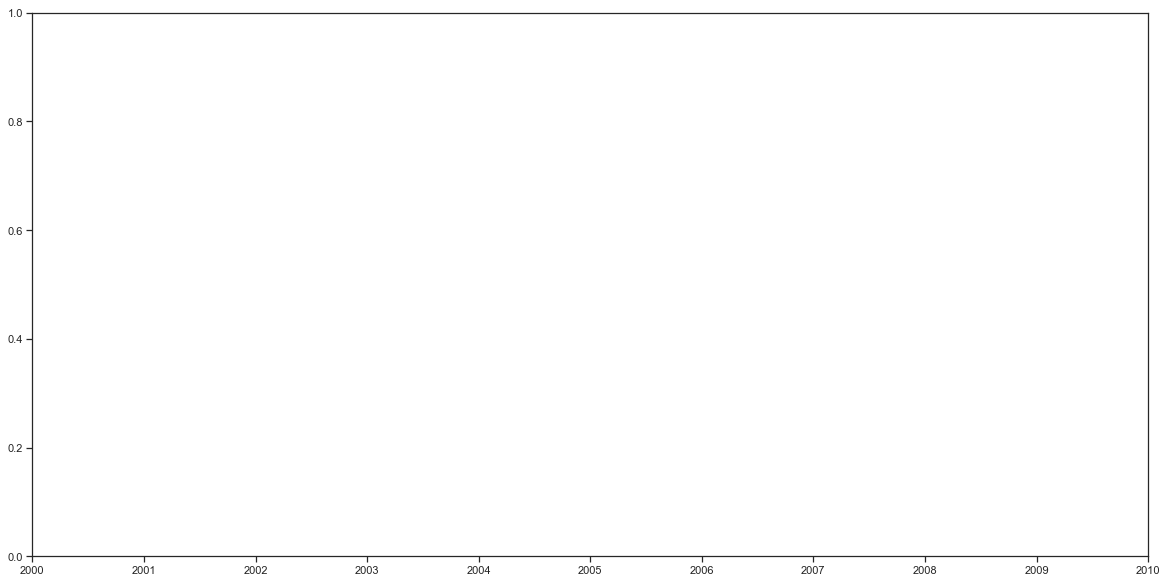

In [1265]:
    
plt.figure(figsize=(20, 10))
plt.plot(forecast, color='r', label="model")
#plt.plot(model_data['Sales'], label="actual")

plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);

AttributeError: 'int' object has no attribute 'toordinal'

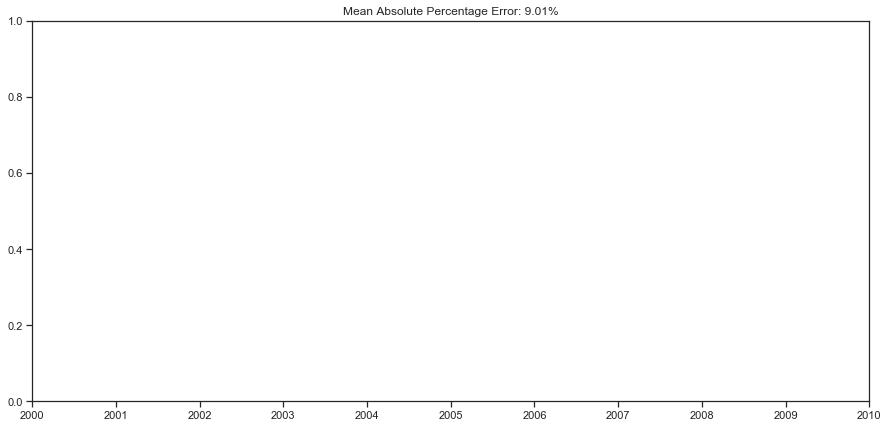

In [1255]:
plt.figure(figsize=(15, 7))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(forecast, color='r', label="model")
plt.axvspan(model_data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(model_data['Sales'], label="actual") 
plt.legend()
plt.grid(True);

In [1204]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    model_data = data.copy()
    model_data.columns = ['Sales']
    model_data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    model_data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = model_data.shape[0], end = model_data.shape[0]+n_steps)
    forecast = model_data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(model_data.values[s+d], model_data['arima_model'][s+d])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(model_data['Sales'], label="actual")
    plt.legend()
    plt.grid(True);

AttributeError: 'int' object has no attribute 'toordinal'

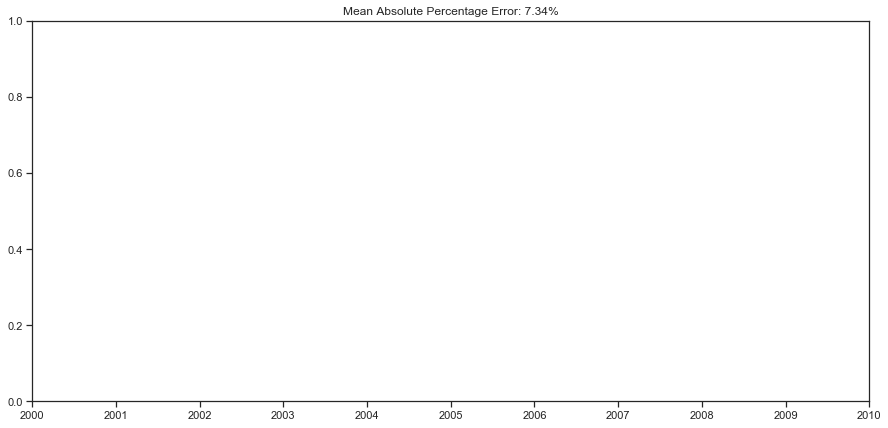

In [1205]:
plotSARIMA(data, best_model, 50)

### Linear models? 

#### Feature extractrion

#### Lags of time series

In [1136]:
# Creating a copy of the initial datagrame to make various transformations 
data_lags = pd.DataFrame(data.copy())
data_lags.columns = ["y"]

In [1139]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data_lags["lag_{}".format(i)] = data_lags.y.shift(i)

In [1140]:
# take a look at the new dataframe 
data_lags.tail(7)

y   lag_6   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  \
Date                                                                         
2015-01-21  4524.0  6032.0  4775.0  5919.0  3067.0  8155.0  6837.0  6405.0   
2015-01-20  3955.0  5258.0  6032.0  4775.0  5919.0  3067.0  8155.0  6837.0   
2015-01-19  4082.0  5931.0  5258.0  6032.0  4775.0  5919.0  3067.0  8155.0   
2015-01-17  2883.0  2575.0  5931.0  5258.0  6032.0  4775.0  5919.0  3067.0   
2015-01-16  5456.0  3206.0  2575.0  5931.0  5258.0  6032.0  4775.0  5919.0   
2015-01-15  5810.0  3728.0  3206.0  2575.0  5931.0  5258.0  6032.0  4775.0   
2015-01-14  6366.0  4524.0  3728.0  3206.0  2575.0  5931.0  5258.0  6032.0   

            lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  lag_19  lag_20  \
Date                                                                         
2015-01-21  5275.0  5260.0  2335.0  3678.0  4653.0  4773.0  3765.0  3647.0   
2015-01-20  6405.0  5275.0  5260.0  2335.0  3678.0  4653.0  4773.0  3765.0   
2015-01-19  6837.0  6405.0  5275.0  5260.0  2335.0  3678.0  4653.0  4773.0   
2015-01-17  8155.0  6837.0  6405.0  5275.0  5260.0  2335.0  3678.0  4653.0   
2015-01-16  3067.0  8155.0  6837.0  6405.0  5275.0  5260.0  2335.0  3678.0   
2015-01-15  5919.0  3067.0  8155.0  6837.0  6405.0  5275.0  5260.0  2335.0   
2015-01-14  4775.0  5919.0  3067.0  8155.0  6837.0  6405.0  5275.0  5260.0   

            lag_21  lag_22  lag_23  lag_24  
Date                                        
2015-01-21  2809.0  7478.0  6113.0  6178.0  
2015-01-20  3647.0  2809.0  7478.0  6113.0  
2015-01-19  3765.0  3647.0  2809.0  7478.0  
2015-01-17  4773.0  3765.0  3647.0  2809.0  
2015-01-16  4653.0  4773.0  3765.0  3647.0  
2015-01-15  3678.0  4653.0  4773.0  3765.0  
2015-01-14  2335.0  3678.0  4653.0  4773.0

In [1141]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [1142]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [1143]:
y = data_lags.dropna().y
X = data_lags.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [1146]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1147]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

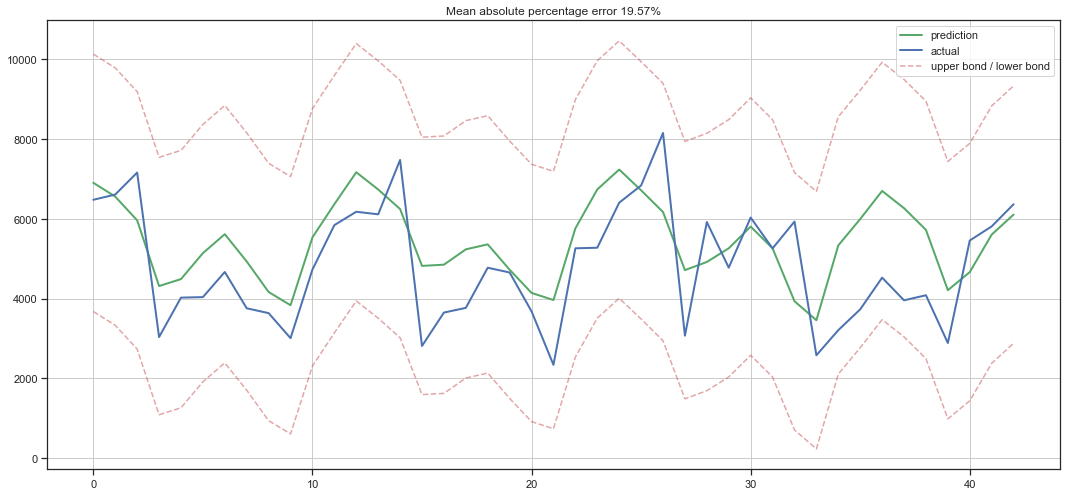

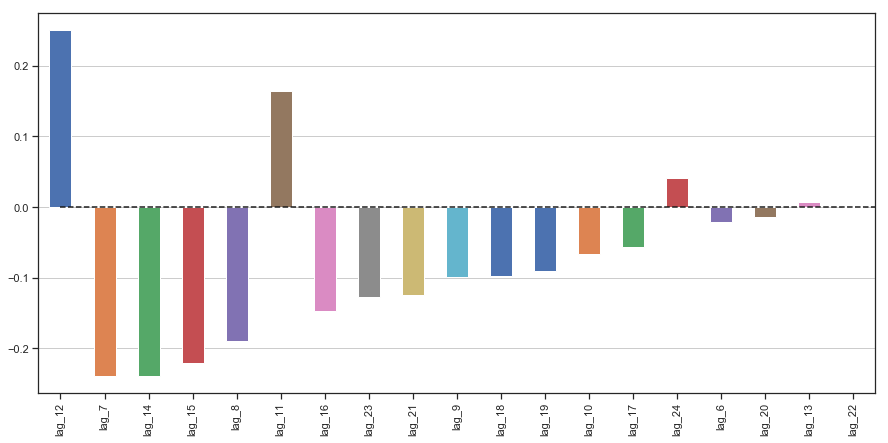

In [1148]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [1149]:
data_lags.index = pd.to_datetime(data_lags.index)
data_lags["hour"] = data_lags.index.hour
data_lags["weekday"] = data_lags.index.weekday
data_lags['is_weekend'] = data_lags.weekday.isin([5,6])*1
data_lags.tail()

y   lag_6   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  \
Date                                                                         
2015-01-19  4082.0  5931.0  5258.0  6032.0  4775.0  5919.0  3067.0  8155.0   
2015-01-17  2883.0  2575.0  5931.0  5258.0  6032.0  4775.0  5919.0  3067.0   
2015-01-16  5456.0  3206.0  2575.0  5931.0  5258.0  6032.0  4775.0  5919.0   
2015-01-15  5810.0  3728.0  3206.0  2575.0  5931.0  5258.0  6032.0  4775.0   
2015-01-14  6366.0  4524.0  3728.0  3206.0  2575.0  5931.0  5258.0  6032.0   

            lag_13  lag_14     ...      lag_18  lag_19  lag_20  lag_21  \
Date                           ...                                       
2015-01-19  6837.0  6405.0     ...      3678.0  4653.0  4773.0  3765.0   
2015-01-17  8155.0  6837.0     ...      2335.0  3678.0  4653.0  4773.0   
2015-01-16  3067.0  8155.0     ...      5260.0  2335.0  3678.0  4653.0   
2015-01-15  5919.0  3067.0     ...      5275.0  5260.0  2335.0  3678.0   
2015-01-14  4775.0  5919.0     ...      6405.0  5275.0  5260.0  2335.0   

            lag_22  lag_23  lag_24  hour  weekday  is_weekend  
Date                                                           
2015-01-19  3647.0  2809.0  7478.0     0        0           0  
2015-01-17  3765.0  3647.0  2809.0     0        5           1  
2015-01-16  4773.0  3765.0  3647.0     0        4           0  
2015-01-15  4653.0  4773.0  3765.0     0        3           0  
2015-01-14  3678.0  4653.0  4773.0     0        2           0  

[5 rows x 23 columns]

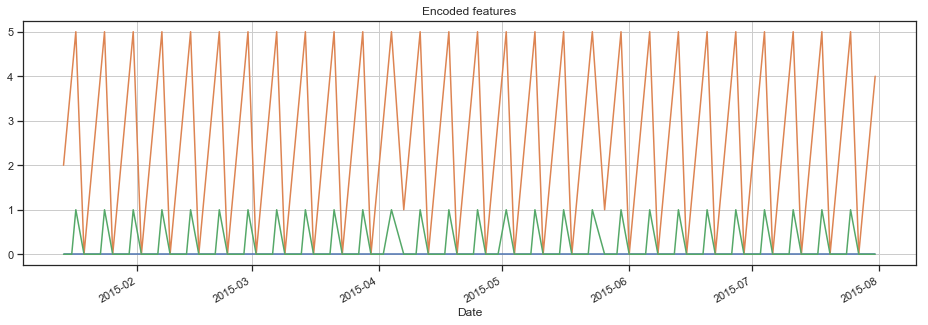

In [1151]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data_lags.hour.plot()
data_lags.weekday.plot()
data_lags.is_weekend.plot()
plt.grid(True);

In [1153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.

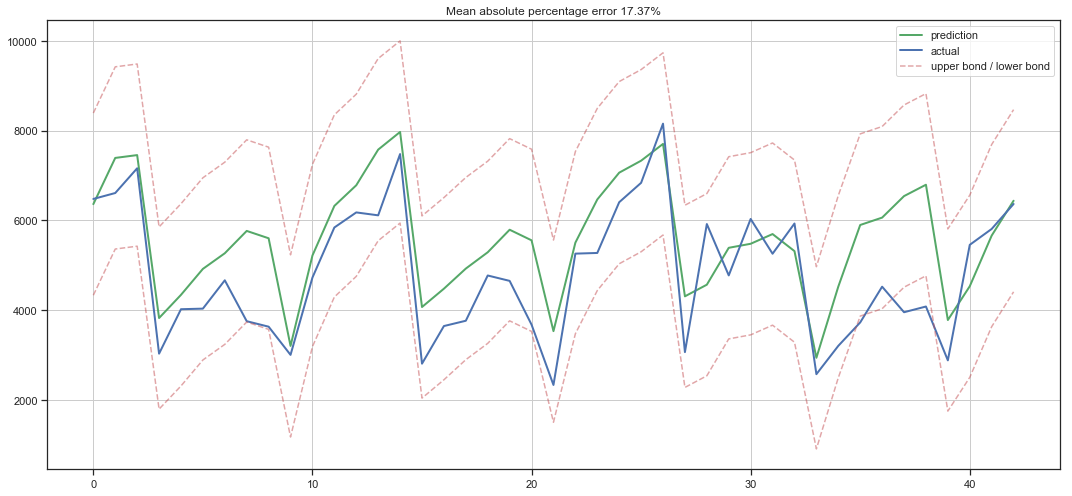

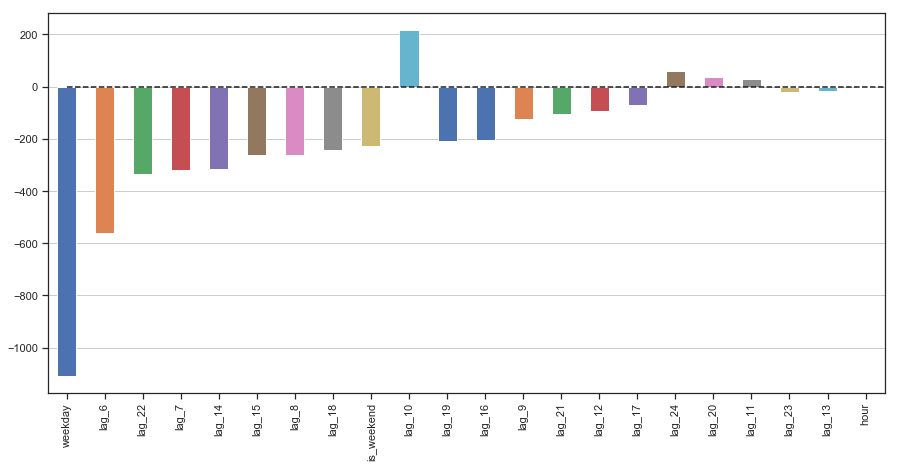

In [1154]:
y = data_lags.dropna().y
X = data_lags.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

#### Target encoding

In [1158]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

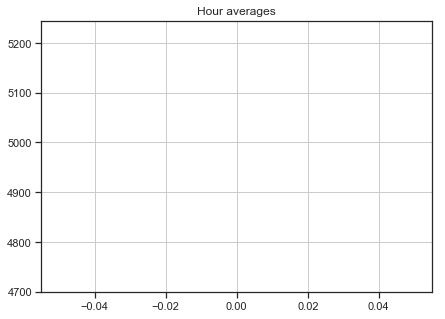

In [1159]:
average_hour = code_mean(data_lags, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

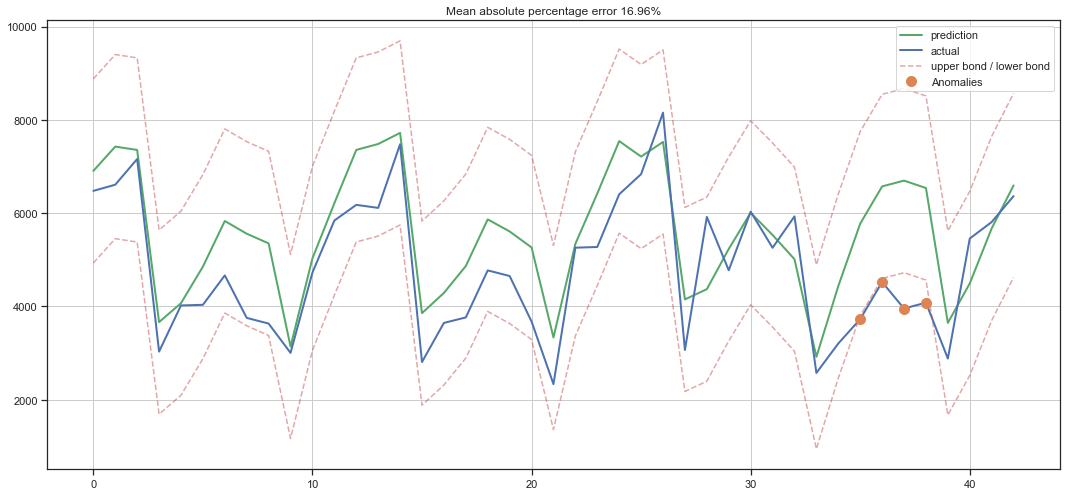

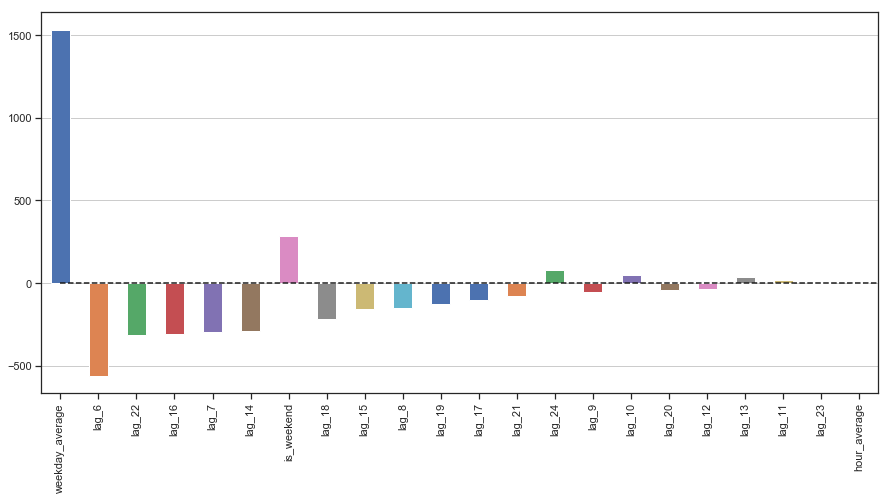

In [1162]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = prepareData(data, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [1163]:
X_train, X_test, y_train, y_test =\
prepareData(data, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Regularization and feature selection

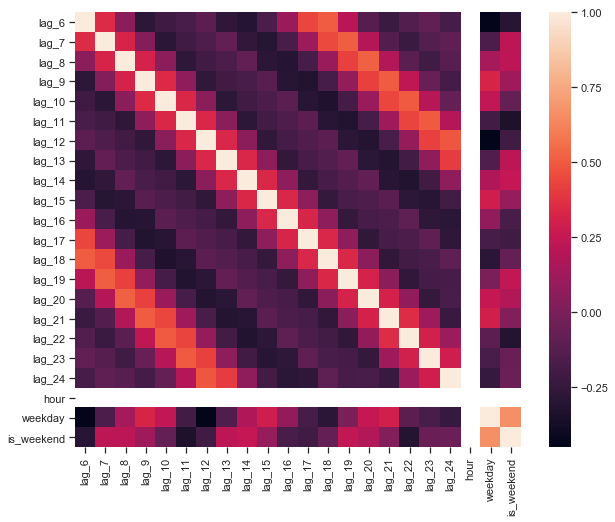

In [1164]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

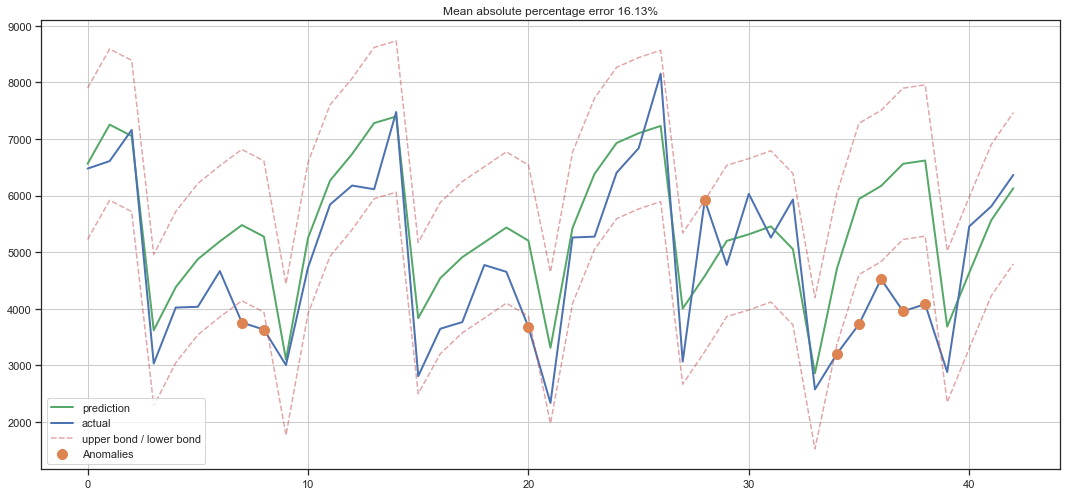

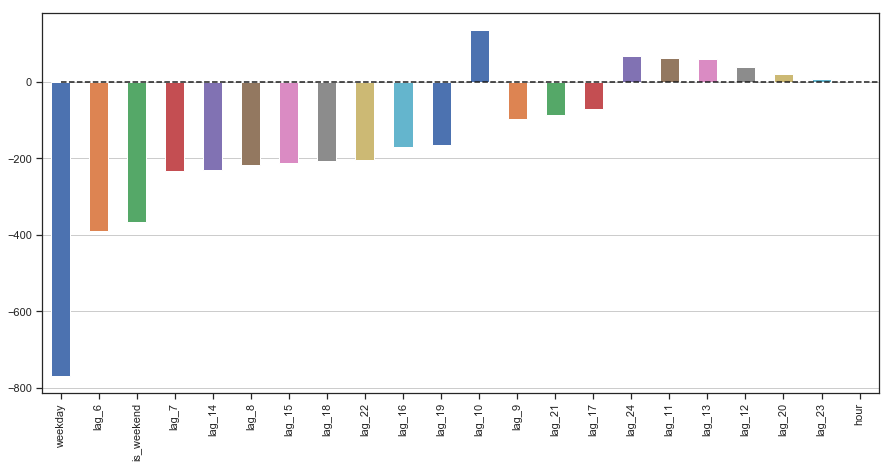

In [1167]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

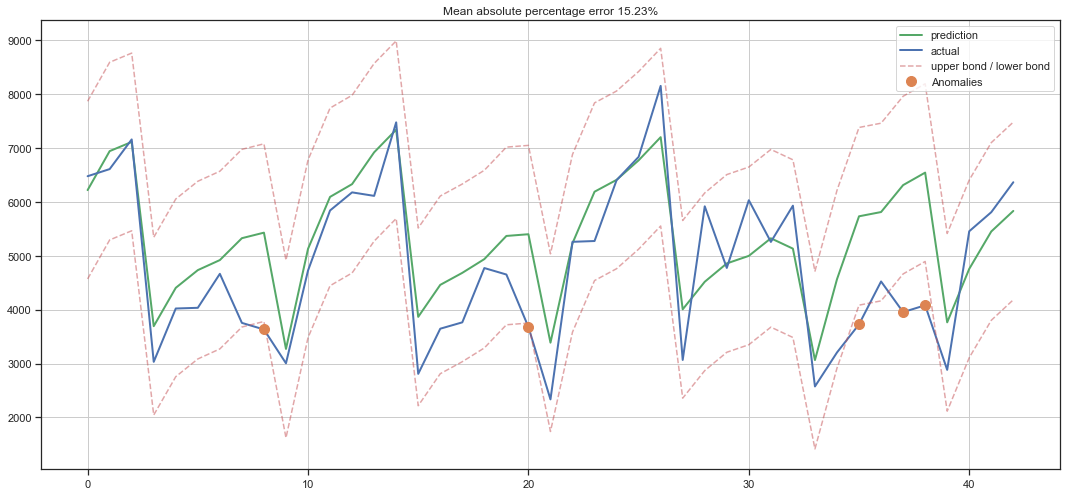

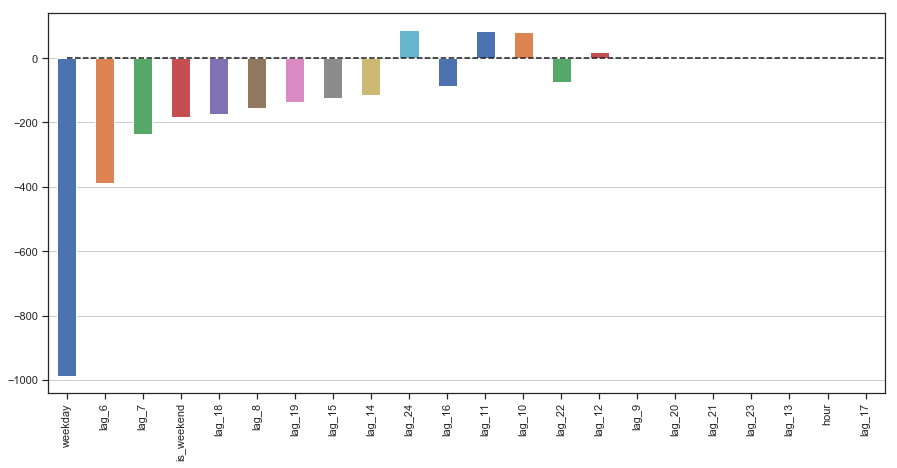

In [1168]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

#### Boosting

In [1169]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

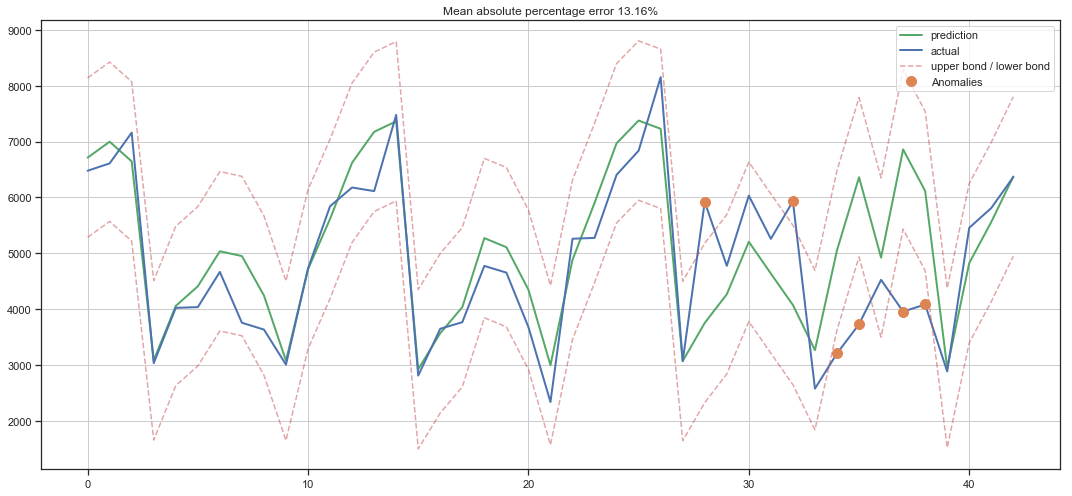

In [1170]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)